# BME 252 Accelerometer Project

Read in sensor values:

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from numpy.linalg import inv
import math as m

#read in data
data = np.loadtxt('daphne_3.csv', delimiter=',', skiprows = 1)
d_aTime = data[:,0]
d_aX = data[:, 1]
d_aY = data[:, 2]
d_aZ = data[:, 3]
d_gTime = data[:, 4]
d_gX = data[:,5]
d_gY = data[:, 6]
d_gZ = data[:, 7]

In [32]:
def plotVals(x,y,identifier):
    'This function accepts plots "x" against "y", and assigns the inputed data to a personal "identifier" for the legend.'
    plt.xlim(0,69)
    plt.plot(x,y, label = identifier)
    plt.ylabel(ylabel, fontsize = 18)
    plt.xlabel('Time (s)', fontsize = 18)
    plt.legend()

In [33]:
def plotLog(x,y,identifier, marker, ind):
    'This function plots "x" against "y" on a log-log scale, and assigns the data a unique id tag'
    'It will also plot a trendline and a specific marker indiciating the min value'

    #Plot allan variance in log-log scale
    plt.figure(figsize = (30,10))
    plt.loglog(x,y, label = identifier)
    
    #Mark location of min value
    plt.plot(x[marker], y[marker],'r-o', markersize = 20)
    
    #Mark location of -0.5 slope
    plt.plot(x[ind], y[ind],'b-o', markersize = 20)
    
    #Determine bias instability
    b = x[ind]*0.5 + y[ind]
    bias = -0.5 + b

    plt.grid(True, which="both")
    plt.ylabel(ylabel, fontsize = 18)
    plt.xlabel('Time (s)', fontsize = 18)
    plt.ylabel('Allan Deviation (degs/s)', fontsize = 18)

    #Annotate noise sources
    plt.annotate('Bias Instability', xy=(x[marker], y[marker]),xytext =(x[marker+1], y[marker+1]),  weight='bold')
    plt.annotate('Random Walk', xy=(x[ind], y[ind]), xytext =(x[ind+1], y[ind+1]), weight='bold')
    title = 'Allan Deviation (' + identifier + ')' 
    plt.title(title, fontsize = 32)
    
    
    #Output noise characterization
    if((identifier == 'Ax') | (identifier == 'Ay') | (identifier == 'Az')):
        print('Bias Instability: ' + str(y[marker]*3600) + ' (m/h^2)' )
        print('Velocity Random Walk: ' + str(bias*60) + ' (m/s^2/sqrt(h))' )
    else:
        print('Bias Instability: ' + str(y[marker]*3600) + ' (deg/h^2)' )
        print('Angle Random Walk: ' + str(bias*60) + ' (deg/sqrt(h))' )

In [34]:
def getAdjustedZ(angle,Z):
    factor =  m.cos(angle)
    return Z / factor

In [35]:
def getMaxElement(array):
    absArr = abs(array)
    return array[np.argmax(absArr)]

In [36]:
def getMaxPosElement(array):
    return array[np.argmax(array)]

In [37]:
def getMaxArray(array):
    'Populates an array with the length of "array", with the max value of the input'
    absArr =  abs(array)
    maxValInd = np.argmax(absArr)
    return np.full((np.size(array)), array[maxValInd])

In [38]:
def getMaxIndex(xArray, yArray):
    absArr = abs(yArray)
    return xArray[np.argmax(absArr)]

In [39]:
def getMaxPosIndex(xArray,yArray):
    return xArray[np.argmax(yArray)]

In [40]:
def getMeanArray(array):
    'This function calculates the mean value of "array", and uses it to populate an array with the same length as "array"'
    return np.full((np.size(array)), np.mean(array))

In [41]:
def getIntegral(x1, x2, start):
    'This function calculates the integral of input "x2" over "x1", from the declared starting point "start"'
    return integrate.cumtrapz(x1,x2, initial = start)

In [42]:
def getSlopeInd(x,y):
    'This function calculates the derivative the inputted data and locates instances of -0.5'
    deltax = x[1:len(x)] - x[0:len(x)-1]
    deltay = y[1:len(y)] - y[0:len(y)-1]
    deriv = np.divide(deltay,deltax)
    slopeInd = 0
    for i in range(0, len(deriv)):
        #locate first instance of -0.5 slope
        if((deriv[i] > -0.6) & (deriv[i] < -0.44) & (slopeInd == 0)&(i>6)):
            slopeInd = i
    
    return slopeInd
    

In [43]:
def getPosition(x1, x2, start):
    'Integrates acceleration data twice to determine position'
    v = integrate.cumtrapz(x1, x2, initial = start)
    return integrate.cumtrapz(v, x2, initial = start)

In [44]:
def fixUnits(array):
    'Convert acceleration from g to m/s^2'
    return array * 9.81

In [45]:
def correctAngle(array, angle):
    return array/angle

In [46]:
def getAbsVals(x, y, z):
    return np.sqrt(x**2 + y**2 + z**2)

In [47]:
#Generate velocity & displacement
d_aTime = d_aTime - d_aTime[0]
d_absVals = getAbsVals(d_aXG, d_aYG, d_aZG)
d_absGVals = getAbsVals(d_gX, d_gY, d_gZ)

#Velocity
#Update acceleration units
d_aX2 = fixUnits(d_aXG)
d_aY2 = fixUnits(d_aYG)
d_aZ2 = fixUnits(d_aZG)
d_absVals2 = fixUnits(d_absVals)

d_vXG = getIntegral(d_aX2, d_aTime, 0)
d_vYG = getIntegral(d_aY2, d_aTime, 0)
d_vZG = getIntegral(d_aZ2, d_aTime, 0)
d_vAbsVals = getIntegral(d_absVals2, d_aTime, 0)

#Distance
d_dX = getPosition(d_aX2, d_aTime, 0)
d_dY = getPosition(d_aY2, d_aTime, 0)
d_dZ = getPosition(d_aZ2, d_aTime, 0)
d_dabsVals = getPosition(d_absVals2, d_aTime, 0)

#Angular distance
d_gdX = getIntegral(d_gX, d_gTime, 0)
d_gdY = getIntegral(d_gY, d_gTime, 0)
d_gdZ = getIntegral(d_gZ, d_gTime, 0)
d_gdAbsVals = getIntegral(d_absGVals, d_gTime, 0)

## Acceleration Signals

In [48]:
#First 30 points averaged
X = np.ndarray(30)
Y = np.ndarray(30)
Z = np.ndarray(30)
for i in range(10,40):
	X[i-10] = d_aX[i]
	Y[i-10] = d_aY[i]
	Z[i-10] = d_aZ[i]
#initial
d_aXI = np.mean(X)
d_aYI = np.mean(Y)
d_aZI = np.mean(Z)
 	
#Roll Calculation
angleX = (-1) * m.atan2(d_aYI, m.sqrt(m.pow(d_aXI,2) + m.pow(d_aZI,2)))
#Pitch Calculations
angleY = m.atan2((-1) * d_aXI, d_aYI)
angleZ = 0
 
#Rx,Ry,Rz
Rx = np.matrix(((1,0,0),(0,m.cos(angleX), m.sin(angleX)),(0, -m.sin(angleX), m.cos(angleX))))
Ry = np.matrix(((m.cos(angleY), 0, -m.sin(angleY)),(0,1,0),(m.sin(angleY),0, m.cos(angleY))))
Rz = np.matrix(((m.cos(angleZ), m.sin(angleZ), 0),(-m.sin(angleZ),m.cos(angleZ),0),(0,0,1)))
#Calculate R
R1 = np.dot(Rx,Ry)
R = np.dot(R1,Rz)
#Calculate global coordinates
a_sensor = np.matrix (((d_aX),(d_aY), (d_aX)))
#R needs to be inverted
Rinv = inv(R)
#Need transpose of a_sensor
#a_sensor = a_sensor.transpose()
a_global = a_sensor
#Compute AGlobal
a_global = np.dot(Rinv,a_sensor)
d_aXG = np.zeros(len(d_aX))
d_aYG = np.zeros(len(d_aY))
d_aZG = np.zeros(len(d_aZ))
print(d_aXG.shape)
for i in range(0,2295):
	d_aXG[i]= a_global[0,i]
	d_aYG[i]= a_global[1,i]
	d_aZG[i]= a_global[2,i]
d_aXG = np.transpose(d_aXG)
d_aYG = np.transpose(d_aYG)
d_aZG = np.transpose(d_aZG)
 
print(d_aXG)
print("Shape of Array")
print("")
print (d_aXG.shape)
print(d_aX)
print(d_aYG)
print(d_aY)
print(d_aZG)
print(d_aZ)
 

(2295,)
[-0.02449975 -0.02627606 -0.02146676 ...,  0.00111837 -0.00062573
 -0.00499585]
Shape of Array

(2295,)
[ 0.02919006  0.03082275  0.02635193 ...,  0.00610352  0.00765991
  0.01153565]
[-0.28123181 -0.28107134 -0.27936556 ..., -0.30310332 -0.30096214
 -0.29457426]
[-0.28482056 -0.28416443 -0.28372192 ..., -0.31455994 -0.31185913
 -0.30403137]
[ 0.05599378  0.05438728  0.05814672 ...,  0.08455524  0.08243095
  0.07682618]
[-0.94773865 -0.94715881 -0.94815063 ..., -0.94752502 -0.9445343
 -0.93312073]


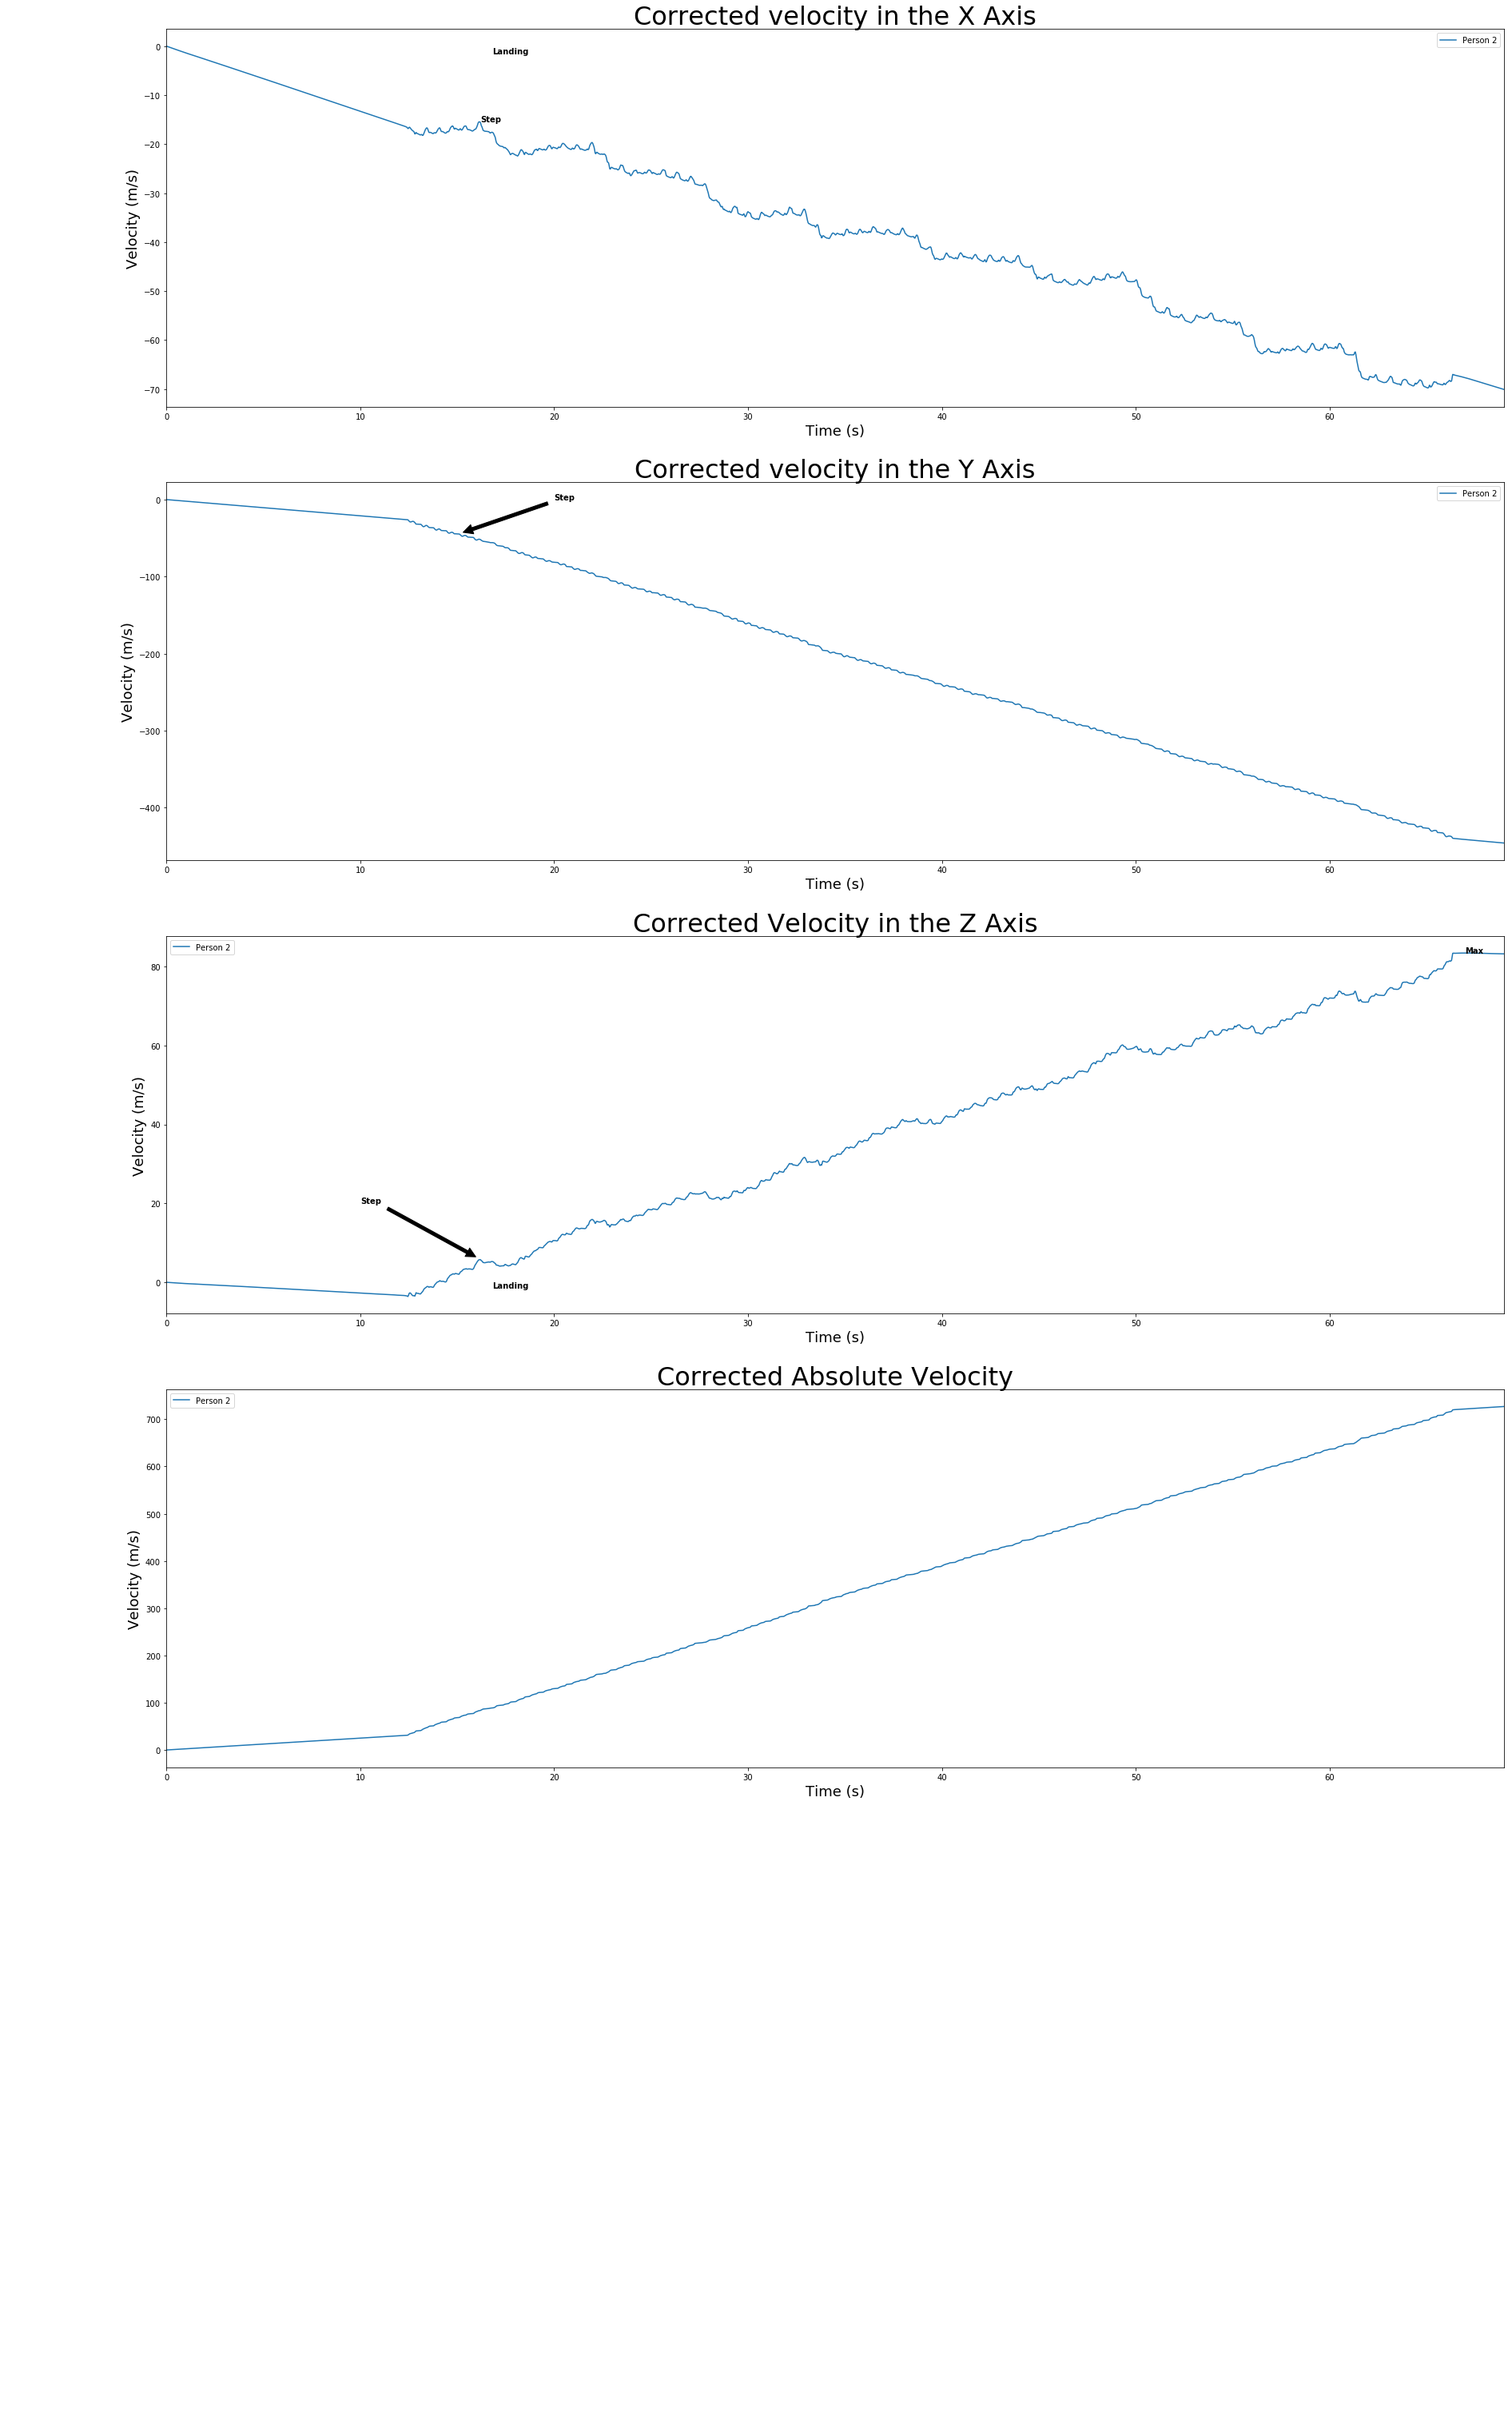

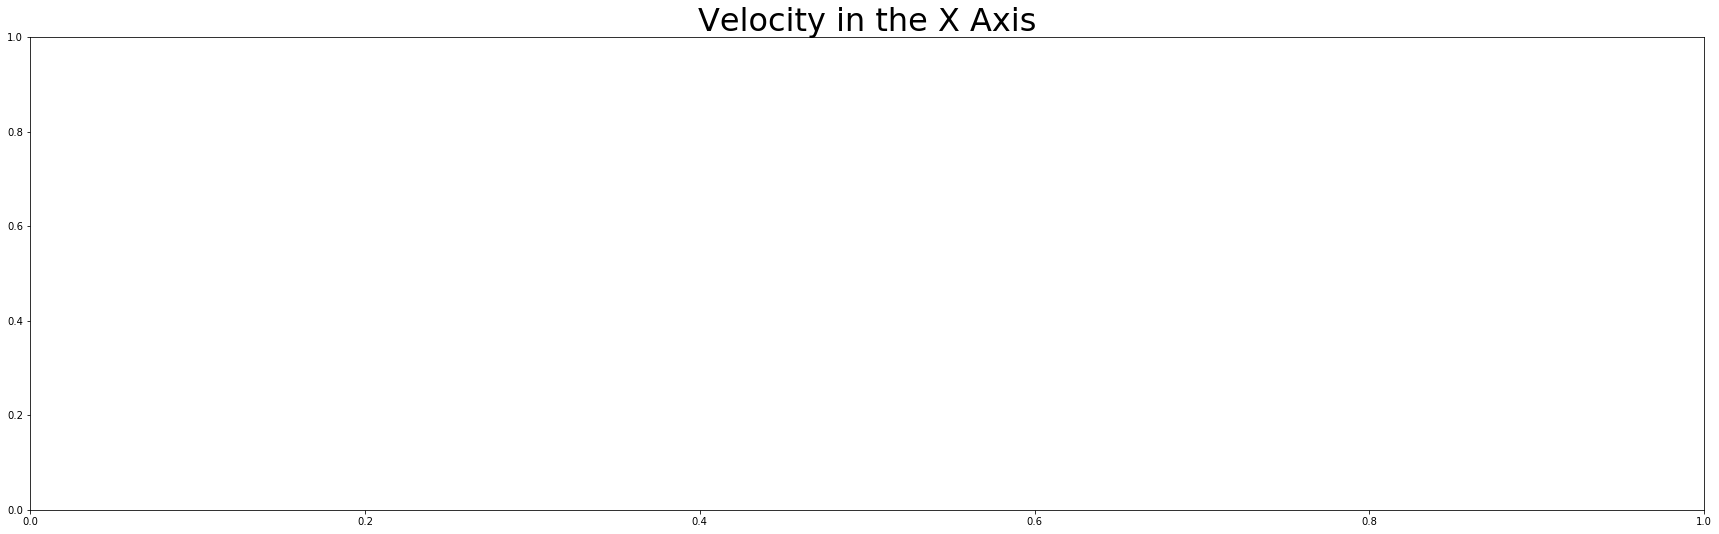

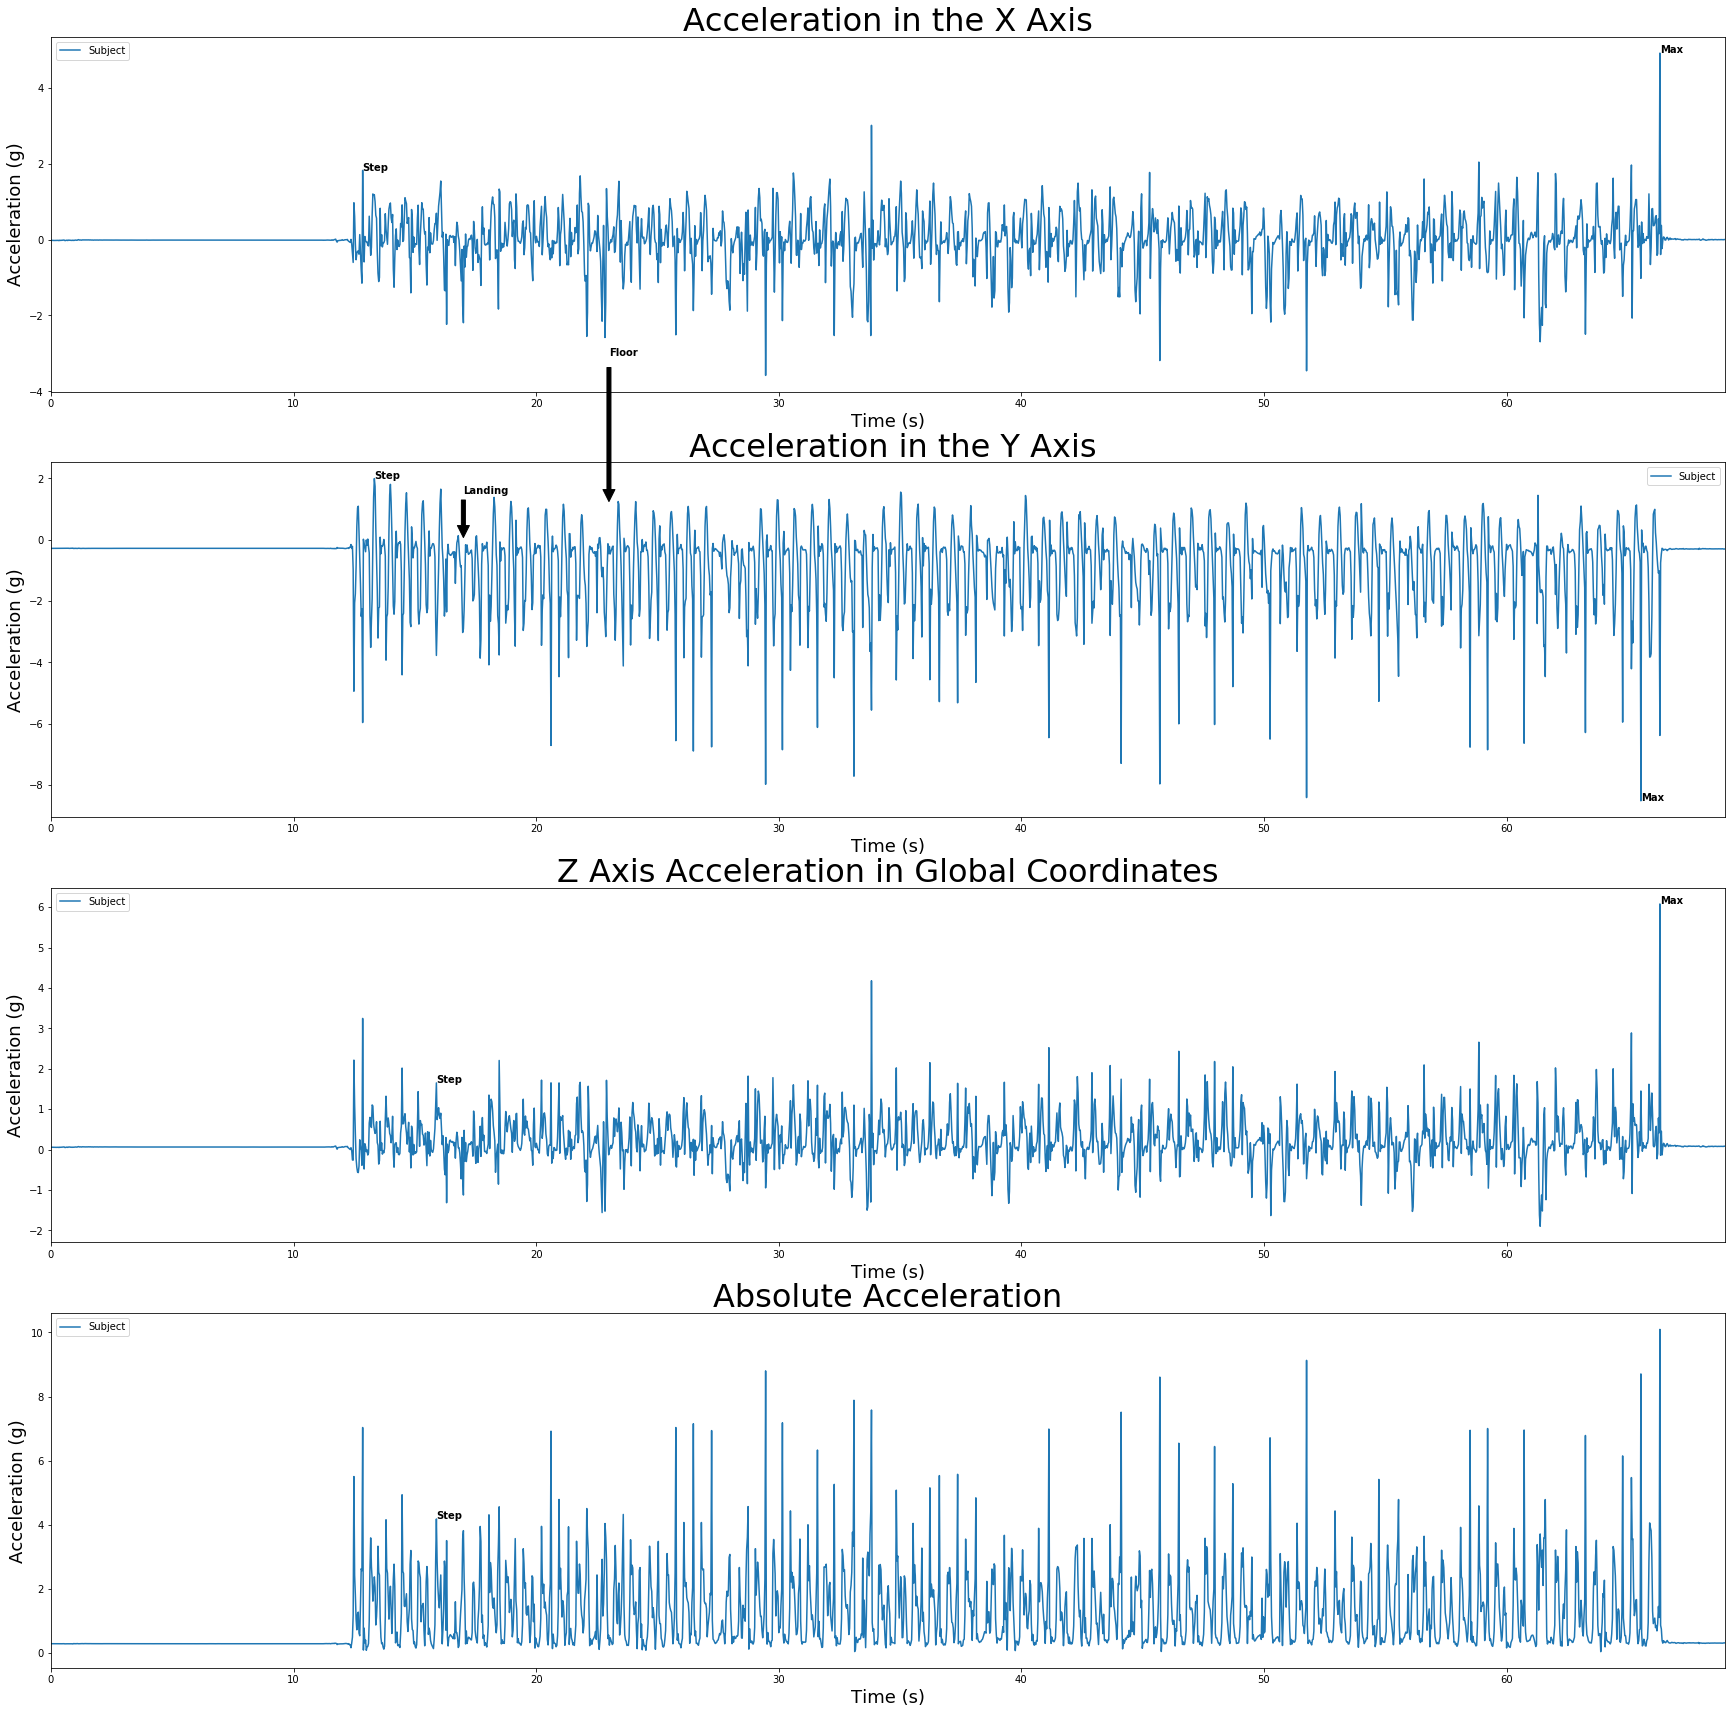

In [49]:
plt.figure(figsize = (30,30))
d_aTime = d_aTime - d_aTime[0]
d_absVals = getAbsVals(d_aXG, d_aYG, d_aZG)

ylabel = 'Acceleration (g)'
plt.subplot(4,1,1)
plt.title('Acceleration in the X Axis', fontsize=32)
plotVals(d_aTime, d_aXG,'Subject')
plt.annotate('Max', xy=(getMaxIndex(d_aTime,d_aXG),getMaxElement(d_aXG)), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_aTime,d_aXG[:500]), getMaxPosElement(d_aXG[:500])), weight='bold')

plt.subplot(4,1,2)
plt.title(' Acceleration in the Y Axis', fontsize=32)
plotVals(d_aTime, d_aYG,'Subject')
plt.annotate('Max', xy=(getMaxIndex(d_aTime,d_aYG),getMaxElement(d_aYG)), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_aTime,d_aYG[:500]), getMaxPosElement(d_aYG[:500])), weight='bold')
plt.annotate('Landing', xy=(17,0), xytext=(17,1.5), weight='bold', arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Floor', xy=(23,1), xytext=(23,6), weight='bold', arrowprops=dict(facecolor='black', shrink=0.05))

plt.subplot(4,1,3)
plt.title('Z Axis Acceleration in Global Coordinates', fontsize=32)
plotVals(d_aTime, d_aZG,'Subject')
plt.annotate('Max', xy=(getMaxIndex(d_aTime,d_aZG),getMaxElement(d_aZG)), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_aTime[500:600],d_aZG[500:600]), getMaxPosElement(d_aZG[500:600])), weight='bold')

plt.subplot(4,1,4)
plt.title('Absolute Acceleration', fontsize=32)
plotVals(d_aTime, d_absVals,'Subject')
plt.annotate('Step', xy=(getMaxPosIndex(d_aTime[500:600],d_absVals[500:600]), getMaxPosElement(d_absVals[500:600])), weight='bold')

plt.show()

## Rotational Velocity

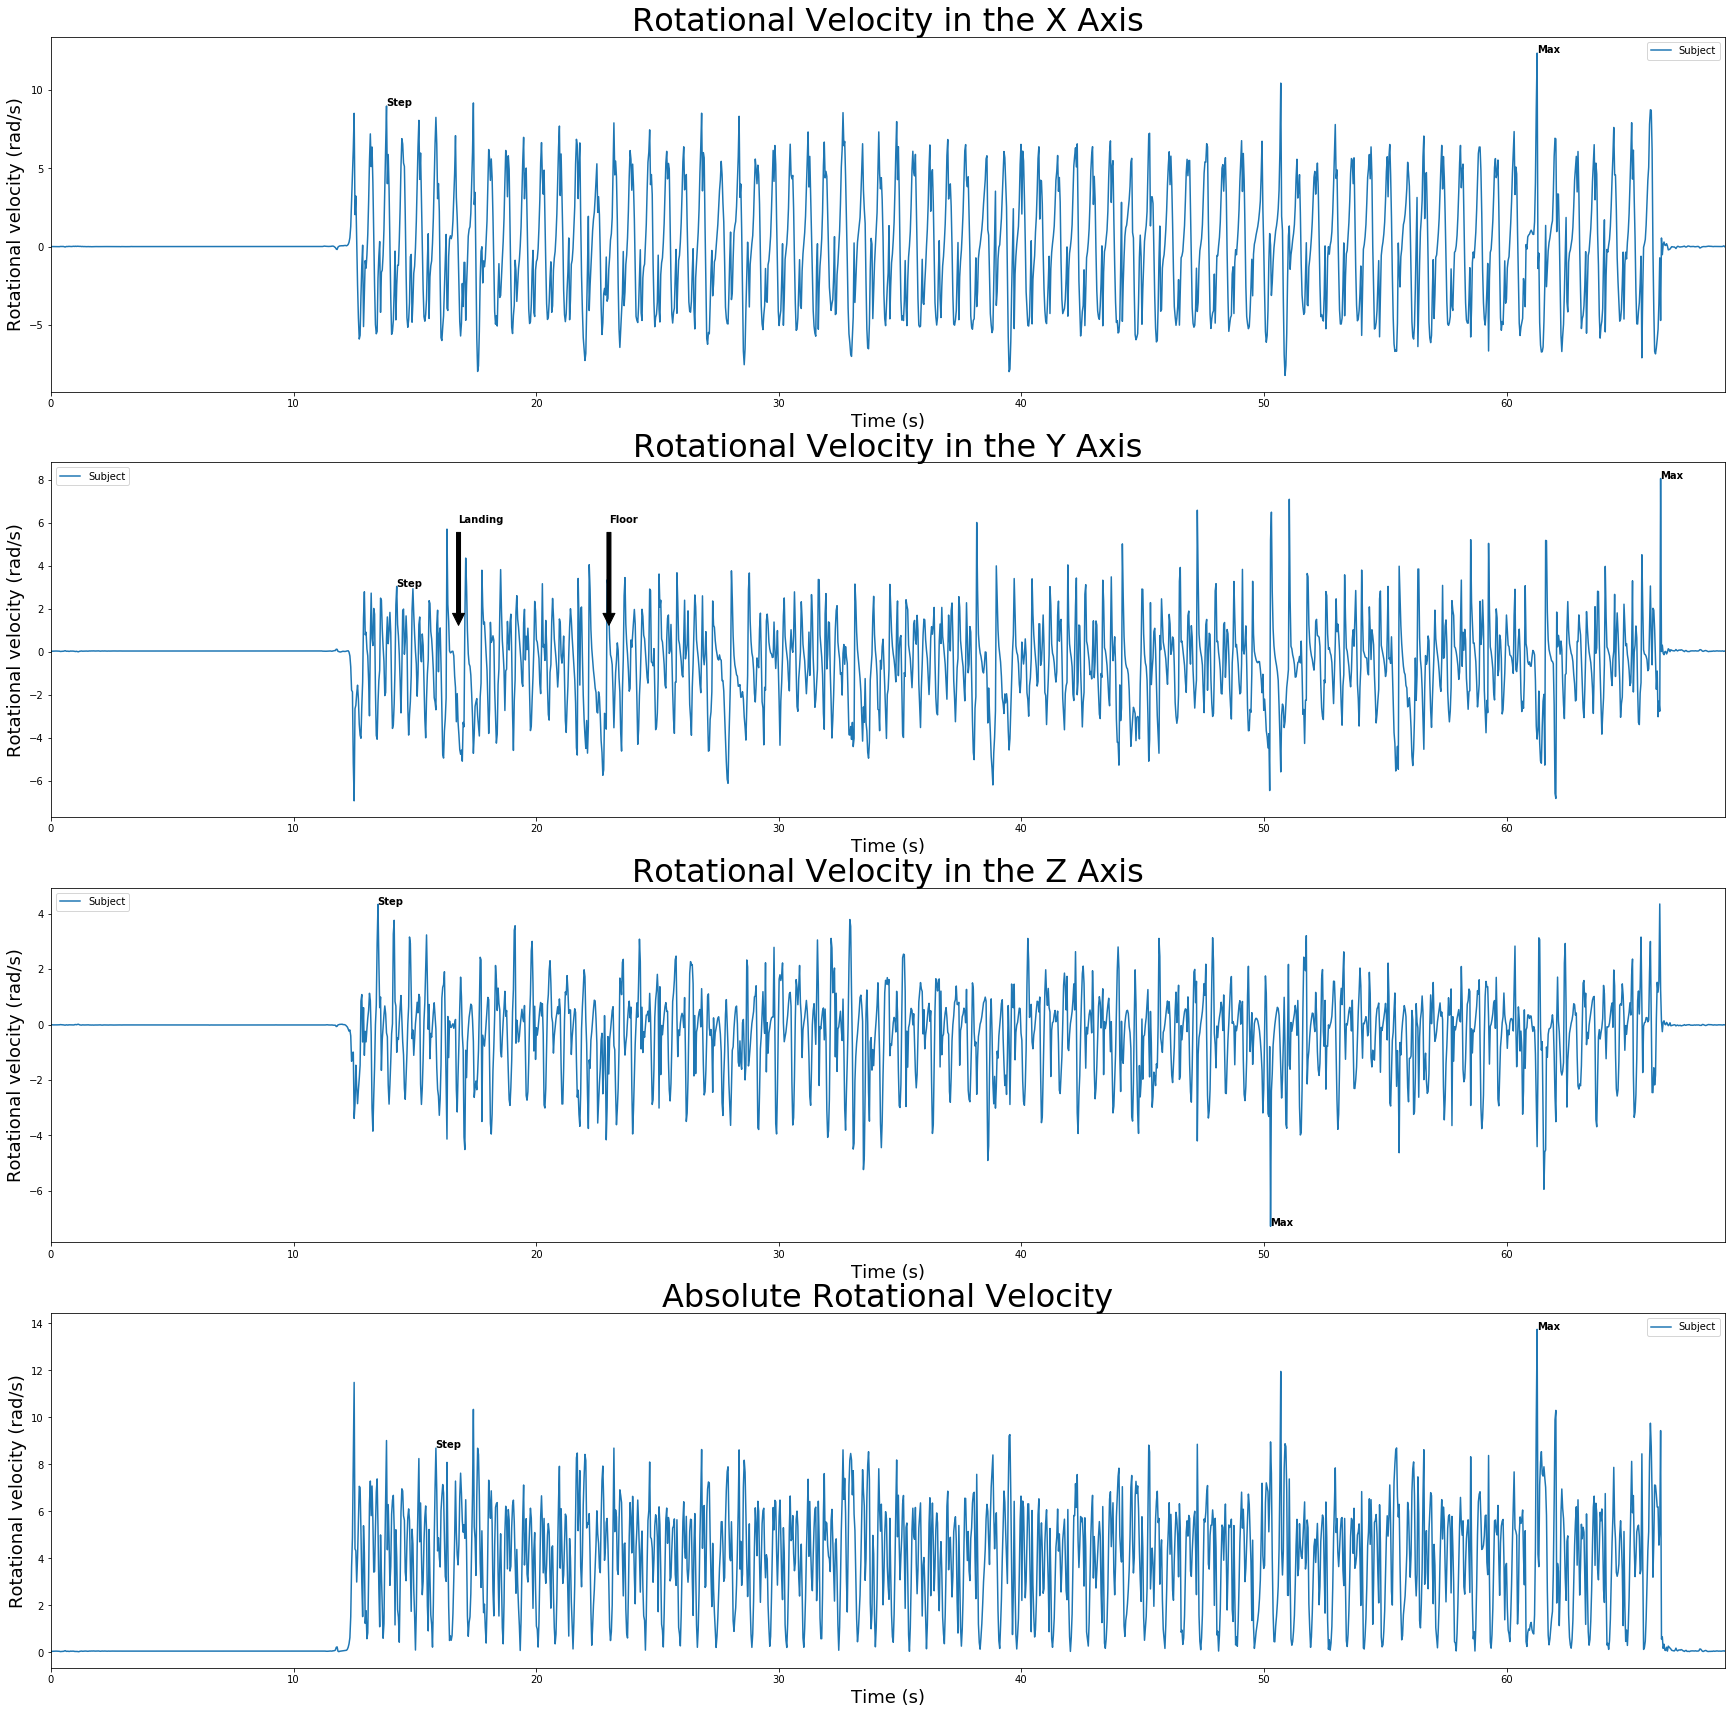

In [50]:
#plot rotational velocities
d_absGVals = getAbsVals(d_gX, d_gY, d_gZ)

plt.figure(figsize = (30,30))
d_gTime = d_gTime - d_gTime[0]
ylabel = 'Rotational velocity (rad/s)'
plt.subplot(4,1,1)
plt.title('Rotational Velocity in the X Axis', fontsize = 32)
plotVals(d_gTime, d_gX, 'Subject')
plt.annotate('Max', xy=(getMaxIndex(d_gTime,d_gX),getMaxElement(d_gX)), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_aTime[:500],d_gX[:500]), getMaxPosElement(d_gX[:500])), weight='bold')

plt.subplot(4,1,2)
plt.title('Rotational Velocity in the Y Axis', fontsize = 32)
plotVals(d_gTime, d_gY, 'Subject')
plt.annotate('Max', xy=(getMaxIndex(d_gTime,d_gY),getMaxElement(d_gY)), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_aTime,d_gY[:500]), getMaxPosElement(d_gY[:500])), weight='bold')
plt.annotate('Landing', xy=(16.8,1), xytext=(16.8,6), weight='bold', arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Floor', xy=(23,1), xytext=(23,6), weight='bold', arrowprops=dict(facecolor='black', shrink=0.05))

plt.subplot(4,1,3)
plt.title('Rotational Velocity in the Z Axis', fontsize = 32)
plotVals(d_gTime, d_gZ, 'Subject')
plt.annotate('Max', xy=(getMaxIndex(d_gTime,d_gZ),getMaxElement(d_gZ)), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_aTime,d_gZ[:500]), getMaxPosElement(d_gZ[:500])), weight='bold')

plt.subplot(4,1,4)
plt.title('Absolute Rotational Velocity', fontsize = 32)
plotVals(d_gTime, d_absGVals, 'Subject')
plt.annotate('Max', xy=(getMaxIndex(d_gTime,d_absGVals),getMaxElement(d_absGVals)), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_aTime[500:550],d_absGVals[500:550]), getMaxPosElement(d_absGVals[500:550])), weight='bold')

plt.show()

## Angular Distance

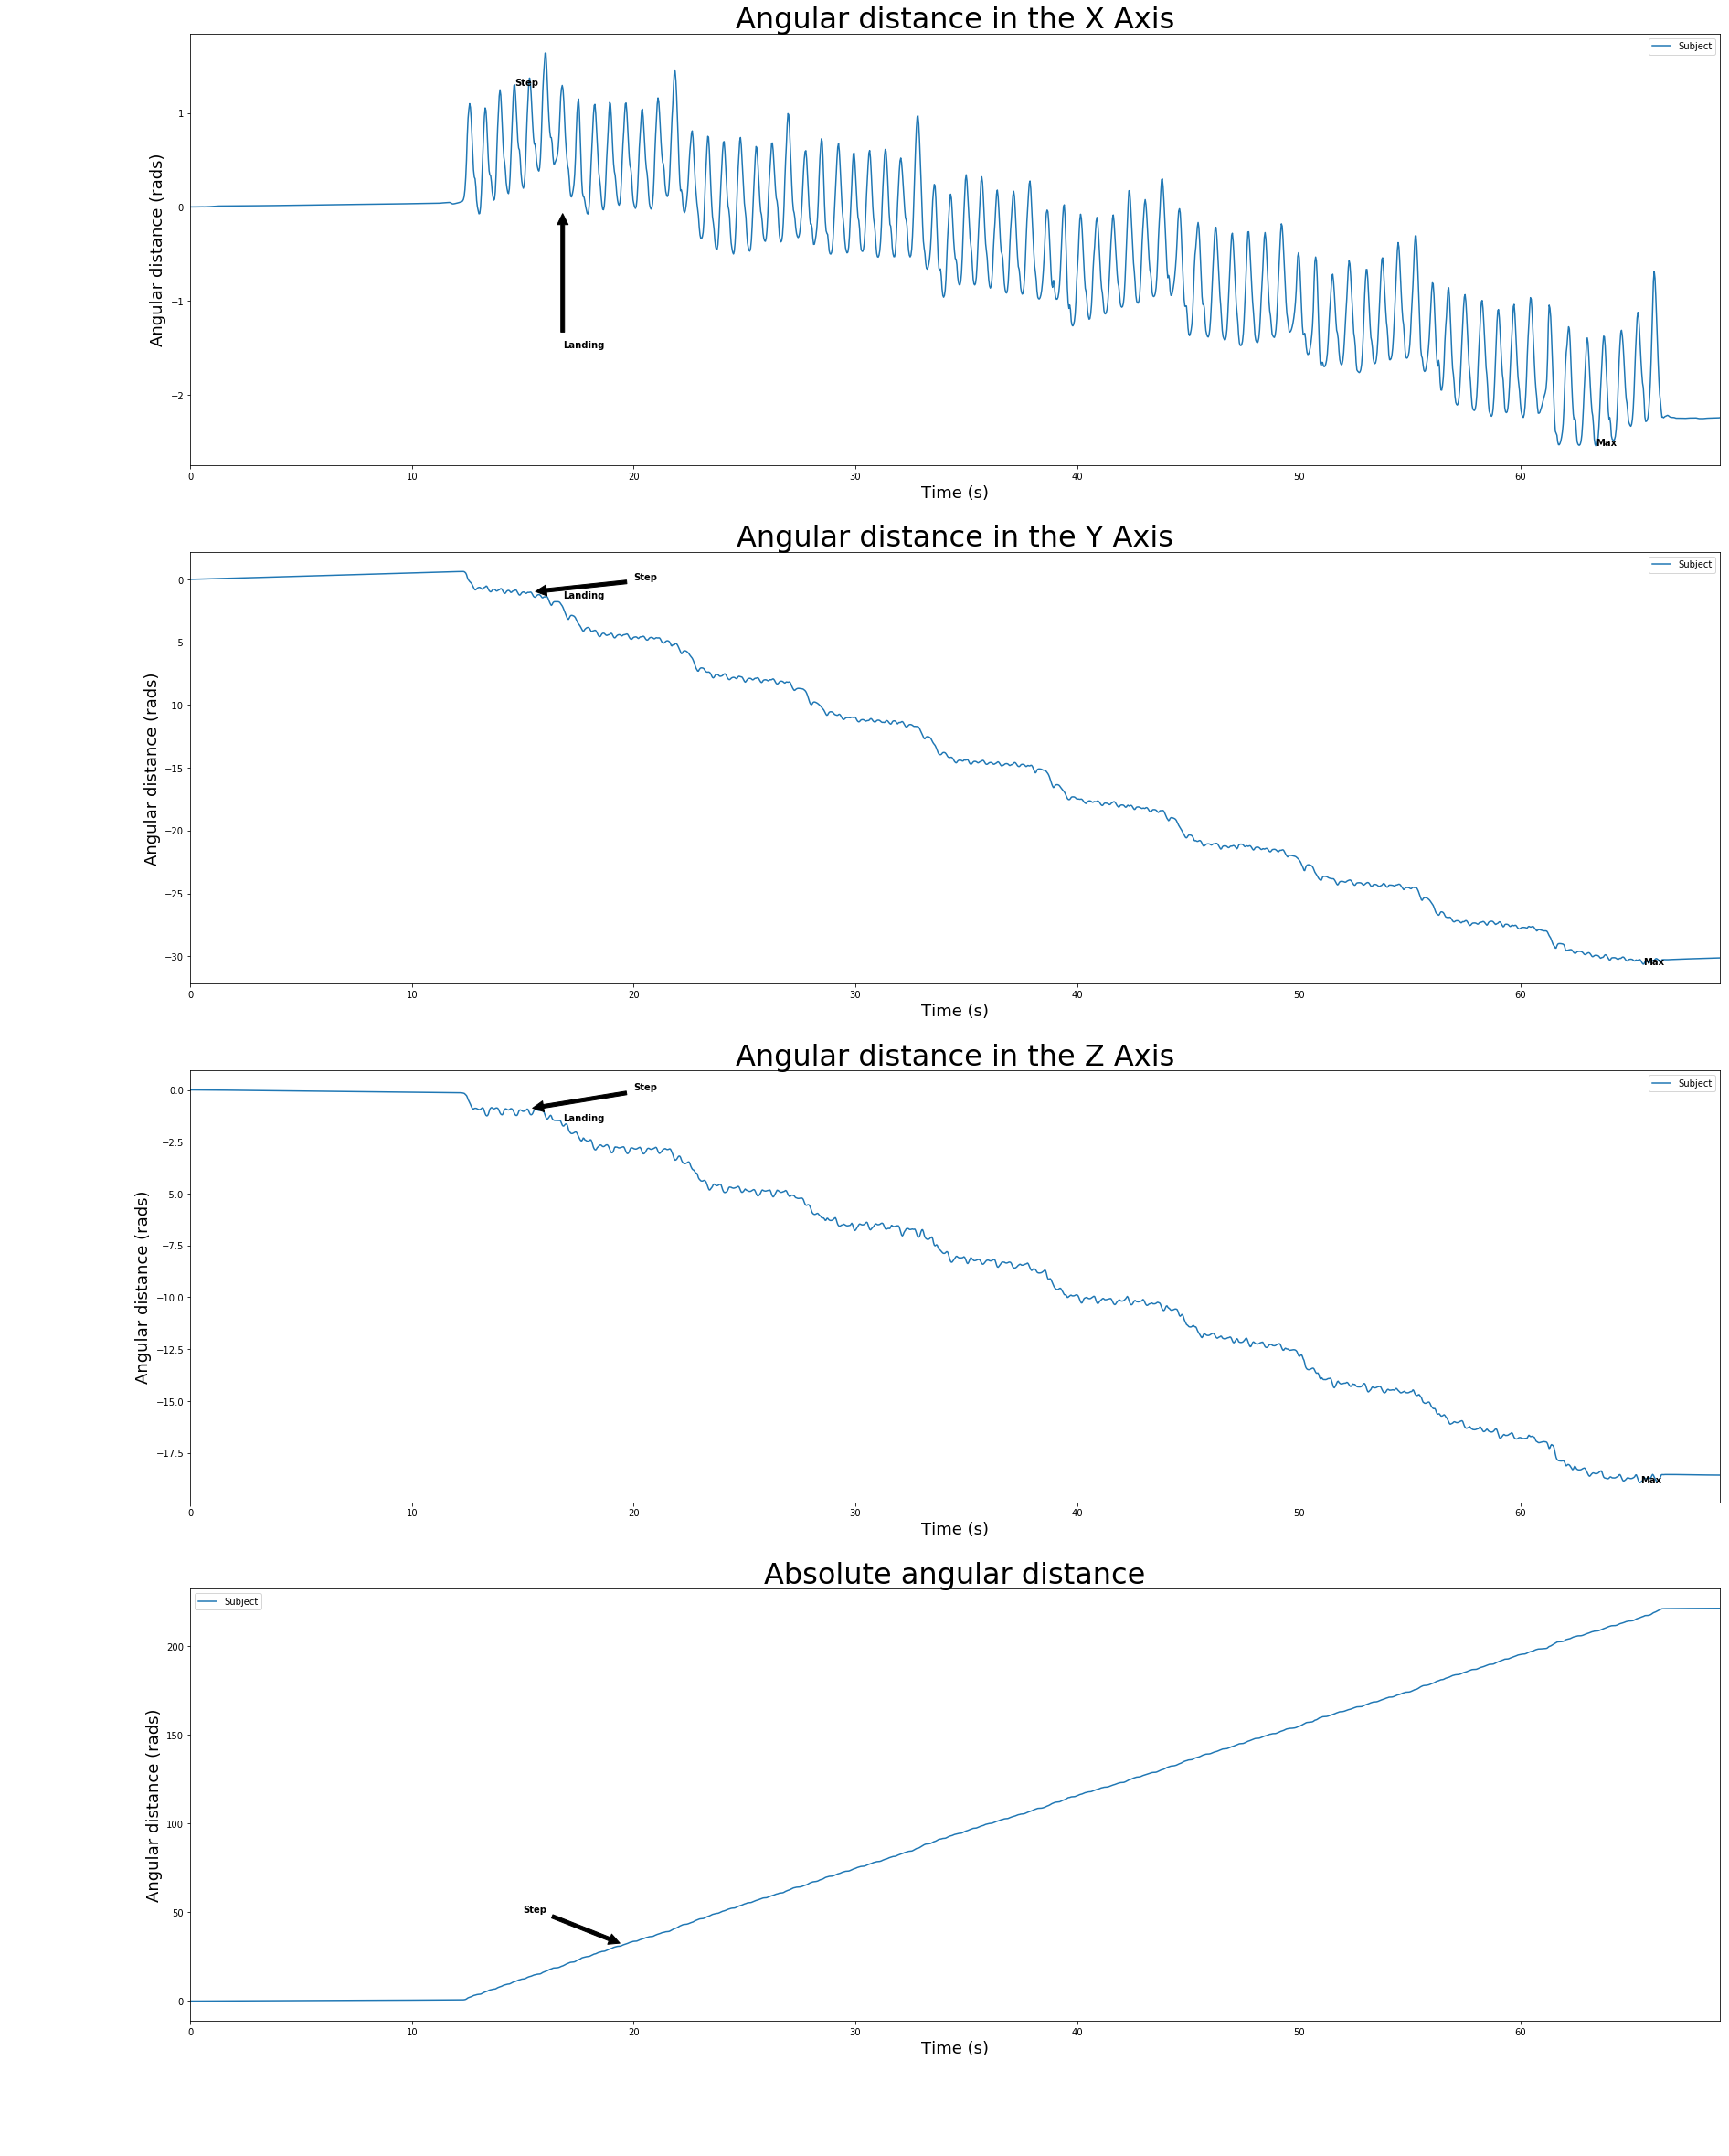

In [51]:
#Calculate angular distance

plt.figure(figsize = (30,40))
plt.subplot(4,1,1)
ylabel = 'Angular distance (rads)'
plt.title('Angular distance in the X Axis', fontsize = 32)
plotVals(d_gTime, d_gdX, 'Subject')
plt.annotate('Max', xy=(getMaxIndex(d_gTime,d_gdX),getMaxElement(d_gdX)), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_gTime,d_gdX[:500]), getMaxPosElement(d_gdX[:500])), weight='bold')
plt.annotate('Landing', xy=(16.8,0), xytext=(16.8,-1.5), weight='bold', arrowprops=dict(facecolor='black', shrink=0.05))

plt.subplot(4,1,2)
plt.title('Angular distance in the Y Axis', fontsize = 32)
plotVals(d_gTime, d_gdY, 'Subject')
plt.annotate('Max', xy=(getMaxIndex(d_gTime,d_gdY),getMaxElement(d_gdY)), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_gTime[500:550],d_gdY[500:550]), 
                         getMaxPosElement(d_gdY[500:550])), weight='bold',
             xytext=(20,0), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Landing', xy=(16.8,0), xytext=(16.8,-1.5), weight='bold')

plt.subplot(4,1,3)
plt.title('Angular distance in the Z Axis', fontsize = 32)
plotVals(d_gTime, d_gdZ, 'Subject')
plt.annotate('Max', xy=(getMaxIndex(d_gTime,d_gdZ),getMaxElement(d_gdZ)), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_gTime[500:550],d_gdZ[500:550]), 
                         getMaxPosElement(d_gdZ[500:550])), weight='bold',
             xytext=(20,0), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Landing', xy=(16.8,0), xytext=(16.8,-1.5), weight='bold')

plt.subplot(4,1,4)
plt.title('Absolute angular distance', fontsize = 32)
plotVals(d_gTime, d_gdAbsVals, 'Subject')
plt.annotate('Max', xy=(getMaxIndex(d_gTime,d_gdAbsVals),
                                 getMaxElement(d_gdAbsVals)), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_gTime[600:650],d_gdAbsVals[600:650]), 
                         getMaxPosElement(d_gdAbsVals[600:650])), weight='bold',
             xytext=(15,50), arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

## Velocity Signals

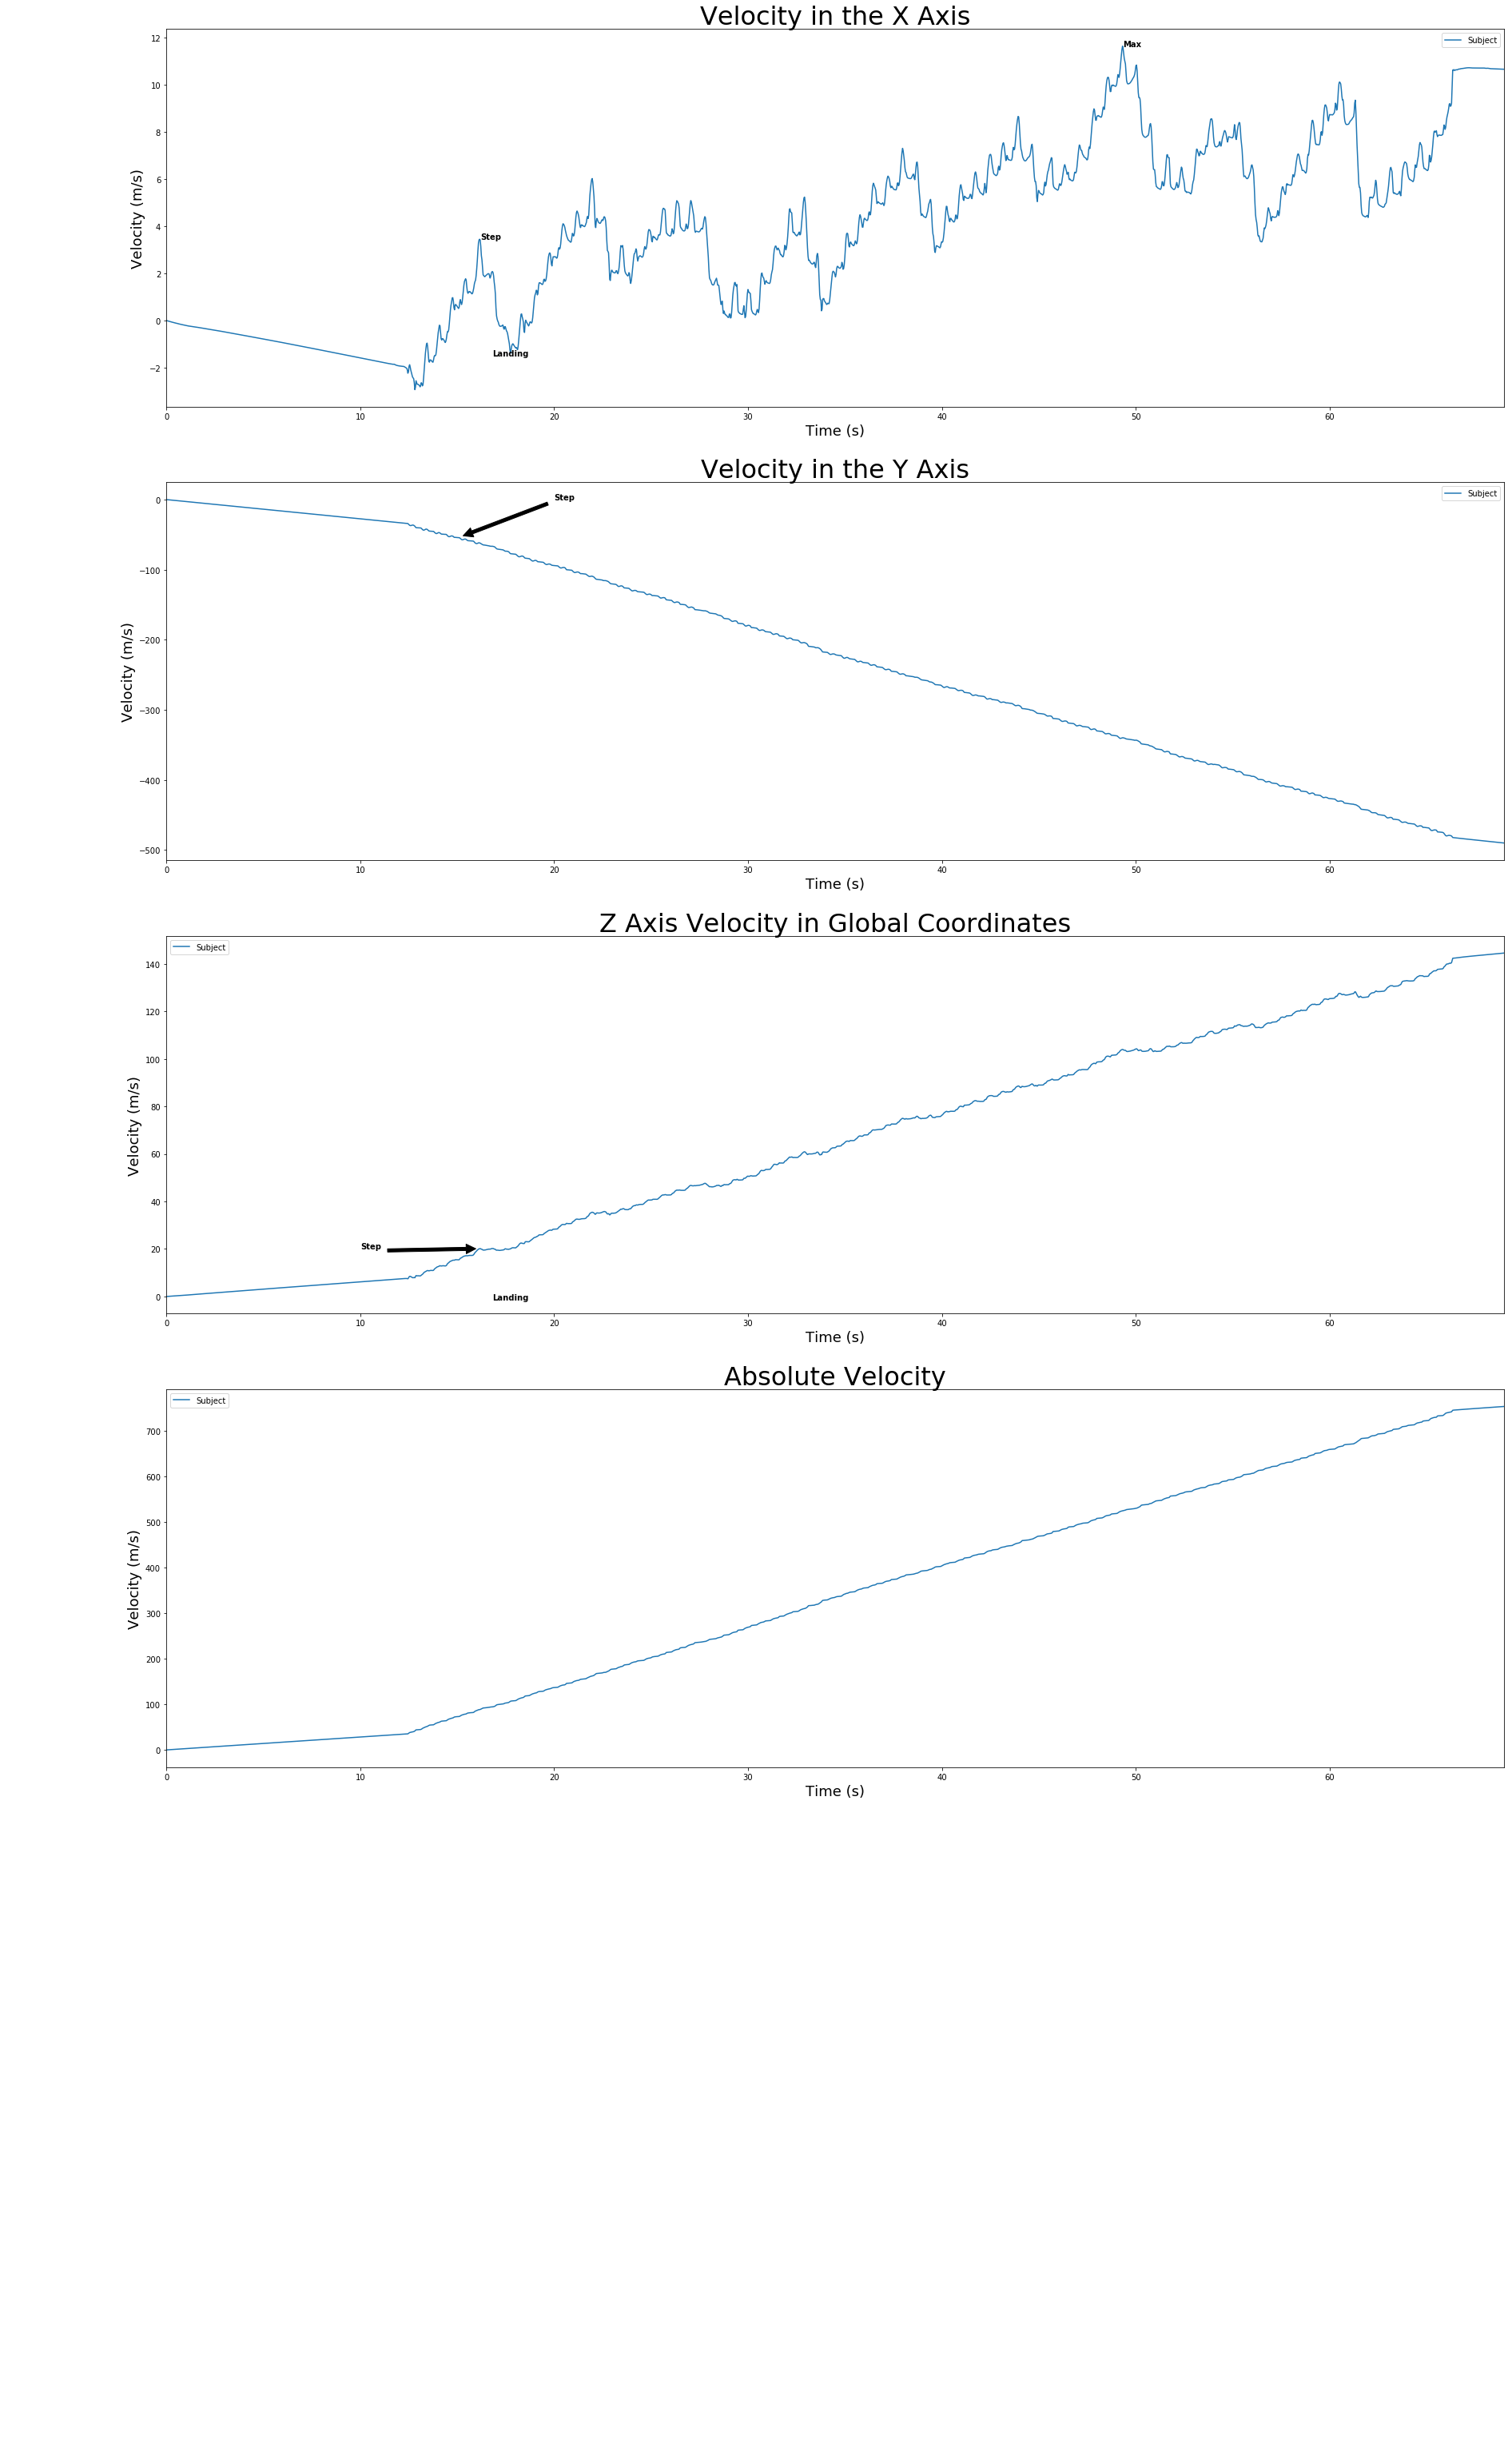

In [52]:
#Calculate velocity

#Update acceleration units
d_aX2 = fixUnits(d_aXG)
d_aY2 = fixUnits(d_aYG)
d_aZ2 = fixUnits(d_aZ)
d_absVals2 = fixUnits(d_absVals)

plt.figure(figsize = (30,40))
plt.subplot(4,1,1)
ylabel = 'Velocity (m/s)'
plt.title('Velocity in the X Axis', fontsize=32)
plotVals(d_aTime, d_vXG, 'Subject')
plt.annotate('Max', xy=(getMaxIndex(d_gTime,d_vXG),getMaxElement(d_vXG)), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_gTime[500:550],d_vXG[500:550]), 
                         getMaxPosElement(d_vXG[500:550])), weight='bold')
plt.annotate('Landing', xy=(16.8,0), xytext=(16.8,-1.5), weight='bold')

plt.subplot(4,1,2)
plt.title('Velocity in the Y Axis', fontsize=32)
plotVals(d_aTime, d_vYG, 'Subject')
plt.annotate('Max', xy=(getMaxIndex(d_gTime,d_vYG),getMaxElement(d_vYG)), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_gTime[500:550],d_vYG[500:550]), 
                         getMaxPosElement(d_vYG[500:550])), weight='bold',
            xytext=(20,0), arrowprops=dict(facecolor='black', shrink=0.05))

plt.subplot(4,1,3)
plt.title('Z Axis Velocity in Global Coordinates', fontsize=32)
plotVals(d_aTime, d_vZG, 'Subject')
plt.annotate('Max', xy=(getMaxIndex(d_gTime,d_vZG),getMaxElement(d_vZG)), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_gTime[500:550],d_vZG[500:550]), 
                         getMaxPosElement(d_vZG[500:550])), weight='bold',
            xytext=(10,20), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Landing', xy=(16.8,0), xytext=(16.8,-1.5), weight='bold')

plt.subplot(4,1,4)
plt.title('Absolute Velocity', fontsize=32)
plotVals(d_aTime, d_vAbsVals, 'Subject')
plt.annotate('Max', xy=(getMaxIndex(d_gTime,d_vAbsVals), getMaxElement(d_vAbsVals)), weight='bold')

plt.show()

## Displacement Signals

In [53]:
#Calculate distance

#Distance X
d_dX = getPosition(d_aX2, d_aTime, 0)

#Distance Y
d_dY = getPosition(d_aY2, d_aTime, 0)

#Distance Z
d_dZ = getPosition(fixUnits(d_aZ), d_aTime, 0)

#Distance Absolute
d_dabsVals = getPosition(d_absVals2, d_aTime, 0)

ylabel = 'Displacement (m)'

plt.figure(figsize = (30,40))
plt.subplot(4,1,1)
plt.title("Displacement in the X Axis", fontsize=32)
plotVals(d_aTime, d_dX, 'Person 2')
plt.annotate('Person 2 max', xy=(getMaxIndex(d_aTime,d_dX), getMaxElement(d_dX)),weight='bold')

plt.subplot(4,1,2)
plt.title("Displacement in the Y Axis", fontsize=32)
plotVals(d_aTime, d_dY, 'Person 2')
plt.annotate('Person 2 max', xy=(getMaxIndex(d_aTime,d_dY), getMaxElement(d_dY)),weight='bold')

plt.subplot(4,1,3)
plt.title("Displacement in the Z Axis", fontsize=32)
plotVals(d_aTime, d_dZ, 'Person 2')
plt.annotate('Person 2 max', xy=(getMaxIndex(d_aTime,d_dZ), getMaxElement(d_dZ)),weight='bold')

#Absolute Distance plot
plt.subplot(4,1,4)
plt.title("Displacement Absolute", fontsize=32)
plotVals(d_aTime, d_dabsVals, 'Person 2')
plt.annotate('Person 2 max', xy=(getMaxIndex(d_aTime,d_dabsVals), getMaxElement(d_dabsVals)),weight='bold')

plt.show()

In [54]:
#Calculating Max and Average Values, replace old code with this code

#1.Max Acceleration
d_max_aX = getMaxArray(d_aX)
print("Max Acceleration X - Person 1, Person 2, Person 3")
print(d_max_aX[0])
print(" ")
d_max_aY = getMaxArray(d_aY)
print("Max Acceleration Y - Person 1, Person 2, Person 3")
print(d_max_aY[0])
print(" ")
d_max_aZ = getMaxArray(d_aZ)
print("Max Acceleration Z - Person 1, Person 2, Person 3")
print(d_max_aZ[0])
print(" ")
d_max_absAVals = getMaxArray(d_absVals)
print("Max Acceleration Absolute - Person 1, Person 2, Person 3")
print(d_max_absAVals[0])
print(" ")

#2.Average Acceleration
d_mean_aX = getMeanArray(d_aX2)
print("Mean Acceleration X - Person 1, Person 2, Person 3")
print(d_mean_aX[0])
print(" ")
d_max_aY = getMeanArray(d_aY2)
print("Mean Acceleration Y - Person 1, Person 2, Person 3")
print(d_max_aY[0])
print(" ")
d_mean_aZ = getMeanArray(d_aZ2)
print("Mean Acceleration Z - Person 1, Person 2, Person 3")
print(d_mean_aZ[0])
print(" ")
d_mean_absVals = getMeanArray(d_absVals2)
print("Mean Acceleration Absolute - Person 1, Person 2, Person 3")
print(d_mean_absVals[0])
print(" ")

#3.Max Velocity
d_max_vX = getMaxArray(getIntegral(d_aX2, d_aTime, 0))
print("Max Velocity X - Person 1, Person 2, Person 3")
print(d_max_vX[0])
print(" ")
d_max_vY = getMaxArray(getIntegral(d_aY2, d_aTime, 0))
print("Max Velocity Y - Person 1, Person 2, Person 3")
print(d_max_vY[0])
print(" ")
d_max_vZ = getMaxArray(getIntegral(d_aZ2, d_aTime, 0))
print("Max Velocity Z - Person 1, Person 2, Person 3")
print(d_max_vZ[0])
print(" ")
d_max_vabsVals = getMaxArray(getIntegral(d_absVals2, d_aTime, 0))
print("Max Velocity Absolute - Person 1, Person 2, Person 3")
print(d_max_vabsVals[0])
print(" ")

#4.Average Velocity
d_mean_vX = getMeanArray(getIntegral(d_aX2, d_aTime, 0))
print("Mean Velocity X - Person 1, Person 2, Person 3")
print(d_mean_vX[0])
print(" ")
d_mean_vY = getMeanArray(getIntegral(d_aY2, d_aTime, 0))
print("Mean Velocity Y - Person 1, Person 2, Person 3")
print(d_mean_vY[0])
print(" ")
d_mean_vZ = getMeanArray(getIntegral(d_aZ2, d_aTime, 0))
print("Mean Velocity Z - Person 1, Person 2, Person 3")
print(d_mean_vZ[0])
print(" ")
d_mean_vabsVals = getMeanArray(getIntegral(d_absVals2, d_aTime, 0))
print("Mean Velocity Absolute - Person 1, Person 2, Person 3")
print(d_mean_vabsVals[0])
print(" ")


#5.Total Displacement
d_max_dX = getMaxArray(getPosition(d_aX2, d_aTime, 0))
print("Displacement X - Person 1, Person 2, Person 3")
print(d_max_dX[0])
print(" ")
d_max_dY = getMaxArray(getPosition(d_aY2, d_aTime, 0))
print("Displacement Y - Person 1, Person 2, Person 3")
print(d_max_dY[0])
print(" ")
d_max_dZ = getMaxArray(getPosition(d_aZ2, d_aTime, 0))
print("Displacement Z - Person 1, Person 2, Person 3")
print(d_max_dZ[0])
print(" ")
d_max_dabsVals = getMaxArray(getPosition(d_absVals2, d_aTime, 0))
print("Displacement Absolute - Person 1, Person 2, Person 3")
print(d_max_dabsVals[0])
print(" ")


#6.Max Angular Velocity
d_max_gX = getMaxArray(d_gX)
print("Max Angular Velocity X - Person 1, Person 2, Person 3")
print(d_max_gX[0])
print(" ")
d_max_gY = getMaxArray(d_gY)
print("Max Angular Velocity Y - Person 1, Person 2, Person 3")
print(d_max_gY[0])
print(" ")
d_max_gZ = getMaxArray(d_gZ)
print("Max Angular Velocity Z - Person 1, Person 2, Person 3")
print(d_max_gZ[0])
print(" ")
d_max_absGVals = getMaxArray(d_absGVals)
print("Max Angular Velocity Absolute - Person 1, Person 2, Person 3")
print(d_max_absGVals[0])
print(" ")

#7.Average Angular Velocity
d_mean_gX = getMeanArray(d_gX)
print("Mean Angular Velocity X - Person 1, Person 2, Person 3")
print(d_mean_gX[0])
print(" ")
d_mean_gY = getMeanArray(d_gY)
print("Mean Angular Velocity Y - Person 1, Person 2, Person 3")
print(d_mean_gY[0])
print(" ")
d_mean_gZ = getMeanArray(d_gZ)
print("Mean Angular Velocity Z - Person 1, Person 2, Person 3")
print(d_mean_gZ[0])
print(" ")
d_mean_absGVals = getMeanArray(d_absGVals)
print("Mean Angular Velocity Absolute - Person 1, Person 2, Person 3")
print(d_mean_absGVals[0])
print(" ")

#8.Max Angular Distance
d_max_dgX = getMaxArray(getIntegral(d_gX, d_gTime, 0))
print("Max Angular Distance X - Person 1, Person 2, Person 3")
print(d_max_dgX[0])
print(" ")
d_max_dgY = getMaxArray(getIntegral(d_gY, d_gTime, 0))
print("Max Angular Distance Y - Person 1, Person 2, Person 3")
print(d_max_dgY[0])
print(" ")
d_max_dgZ = getMaxArray(getIntegral(d_gZ, d_gTime, 0))
print("Max Angular Distance Z - Person 1, Person 2, Person 3")
print(d_max_dgZ[0])
print(" ")
d_max_dabsGVals = getMaxArray(getIntegral(d_absGVals, d_gTime, 0))
print("Max Angular Distance Absolute - Person 1, Person 2, Person 3")
print(d_max_dabsGVals[0])
print(" ")


#9.Average Angular Distance
d_mean_dgX = getMeanArray(getIntegral(d_gX, d_gTime, 0))
print("Mean Angular Distance X - Person 1, Person 2, Person 3")
print(d_mean_dgX[0])
print(" ")
d_mean_dgY = getMeanArray(getIntegral(d_gY, d_gTime, 0))
print("Mean Angular Distance Y - Person 1, Person 2, Person 3")
print(d_mean_dgY[0])
print(" ")
d_mean_dgZ = getMeanArray(getIntegral(d_gZ, d_gTime, 0))
print("Mean Angular Distance Z - Person 1, Person 2, Person 3")
print(d_mean_dgZ[0])
print(" ")
d_mean_dabsGVals = getMeanArray(getIntegral(d_absGVals, d_gTime, 0))
print("Mean Angular Distance Absolute - Person 1, Person 2, Person 3")
print(d_mean_dabsGVals[0])
print(" ")

Max Acceleration X - Person 1, Person 2, Person 3
-4.374847412
 
Max Acceleration Y - Person 1, Person 2, Person 3
-8.55317688
 
Max Acceleration Z - Person 1, Person 2, Person 3
-6.284057617
 
Max Acceleration Absolute - Person 1, Person 2, Person 3
10.0942390605
 
Mean Acceleration X - Person 1, Person 2, Person 3
0.154298826474
 
Mean Acceleration Y - Person 1, Person 2, Person 3
-7.09886128596
 
Mean Acceleration Z - Person 1, Person 2, Person 3
-7.93685248516
 
Mean Acceleration Absolute - Person 1, Person 2, Person 3
10.9019793921
 
Max Velocity X - Person 1, Person 2, Person 3
11.6383861492
 
Max Velocity Y - Person 1, Person 2, Person 3
-490.138071034
 
Max Velocity Z - Person 1, Person 2, Person 3
-547.809757139
 
Max Velocity Absolute - Person 1, Person 2, Person 3
752.764680146
 
Mean Velocity X - Person 1, Person 2, Person 3
3.82034409632
 
Mean Velocity Y - Person 1, Person 2, Person 3
-223.061832958
 
Mean Velocity Z - Person 1, Person 2, Person 3
-281.906384514
 
Mean Ve

## Allan Variance

In [55]:
def binThat(data, size):
    'Splits up data into bins'
    counter = 0
    sumData = 0
    avgData = []
    binLength = size

    for i in range(0, len(data)):
    #ensure the individual has started running
        counter = counter + 1
        sumData = sumData + data[i]

        #check if bin is full, if yes -> take average
        if counter == binLength:
            avg = sumData/binLength 
            avgData.append(avg)
            sumData = 0
            counter = 0
       
    return avgData

In [56]:
def findRunIndex(data):
    'Find onset of running using a single acceleration array'
    baseline = data[1]
    beyondCal = False
    runIndex = 0
    for i in range(0, len(data)):
        if((m.fabs(data[i] - baseline) > 0.01) & (i > 330) & (beyondCal == False)):
            runIndex = i
            beyondCal = True

    return runIndex
        

In [57]:
def removeStand(data, start):
    runArray = []
    for i in range(0, len(data)-1):
        if(i >= start):
            runArray.append(data[i])
    return runArray

In [58]:
def getDev(data):
    totVar = 0
    numBins = len(data)
    for i in range(1, len(data)-1):
        totVar = totVar + (data[i] - data[i-1])**2
    avar = totVar/(2*(numBins-1))

    dev = m.sqrt(avar)
    return dev

In [59]:
def allanize(data, identifier):
    adev = []
    timeArray = []
    #Bin data in sizes up to 201 data points (9 bins)
    for i in range(1,201): #80
         #i = length of bin
        avgArray = binThat(data,i)

        if(i>1):
            adev.append(getDev(avgArray))
            timeArray.append(i/33)

    #Find index of -0.5 slope        
    indSlope = getSlopeInd(np.asarray(timeArray), np.asarray(adev))
    
    #Find 
    
    
    #Find index of the minimum value for bias instability 
    minInd = adev.index(min(adev))
    
    #Plot allan variance graph with marker for min value and slope trendline
    plotLog(timeArray,adev, identifier, minInd, indSlope)
      
    #find for each set of data
    plt.show()

In [60]:
def getAllanVar(data, identifier):

    #find start of running 
    ind = findRunIndex(data)
    #remove standing portion
    corrData = removeStand(data, ind)
    #plot allan variance
    allanize(corrData, identifier)



Bias Instability: 74.2436000461395 (m/h^2)
Velocity Random Walk: -1.7375258839591479 (m/s^2/sqrt(h))


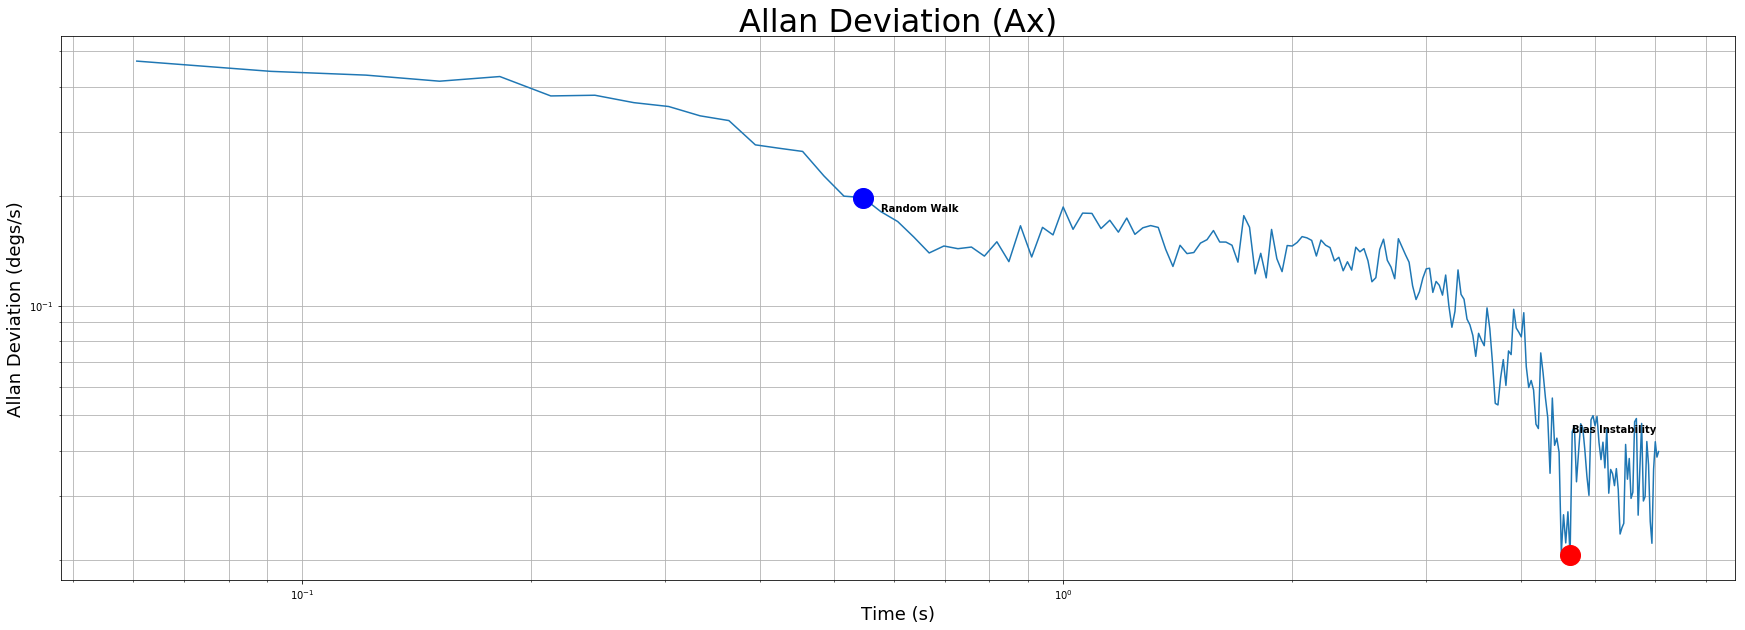

Bias Instability: 125.38416142195454 (m/h^2)
Velocity Random Walk: 5.439865860848068 (m/s^2/sqrt(h))


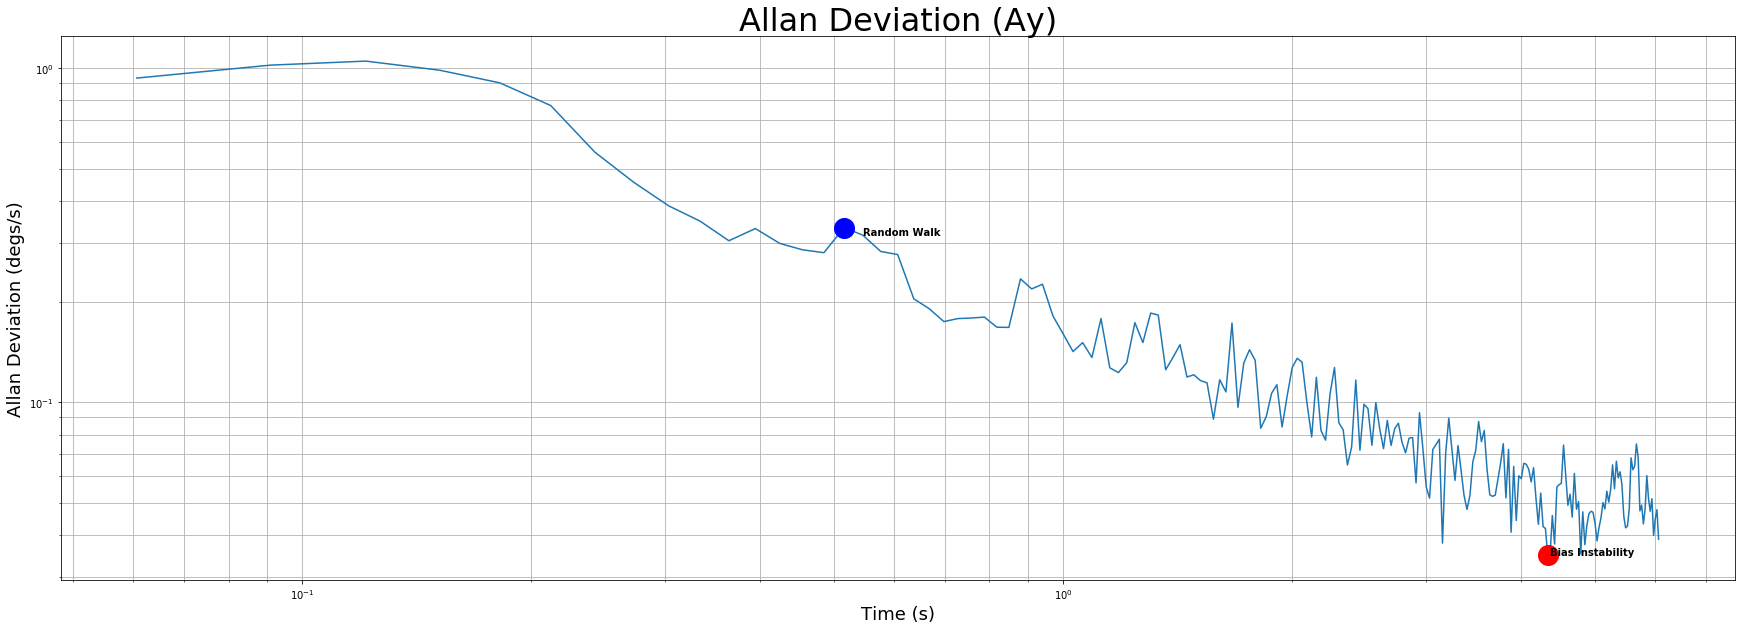

Bias Instability: 67.67037378990489 (m/h^2)
Velocity Random Walk: -3.6325378934907815 (m/s^2/sqrt(h))


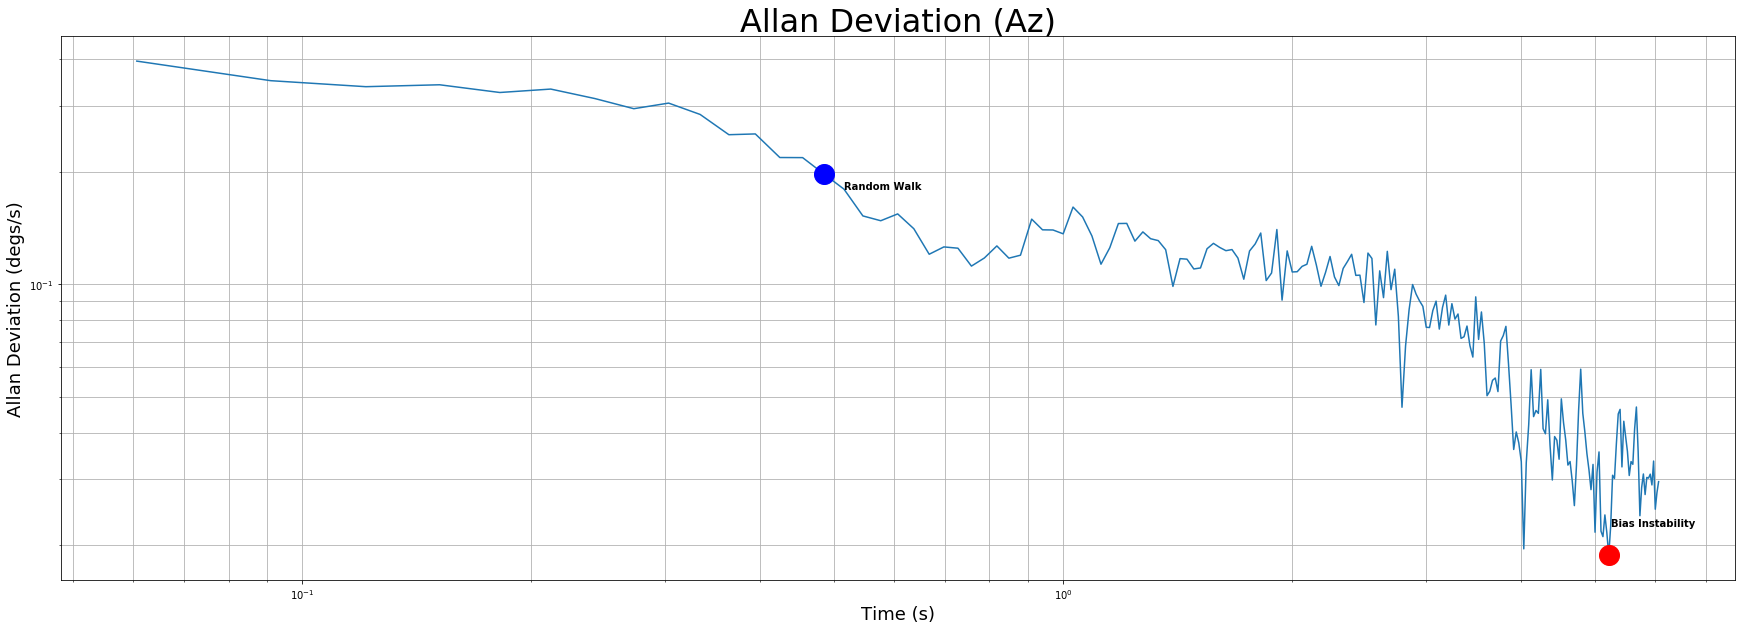

Bias Instability: 182.7818714103055 (deg/h^2)
Angle Random Walk: 53.28778490333615 (deg/sqrt(h))


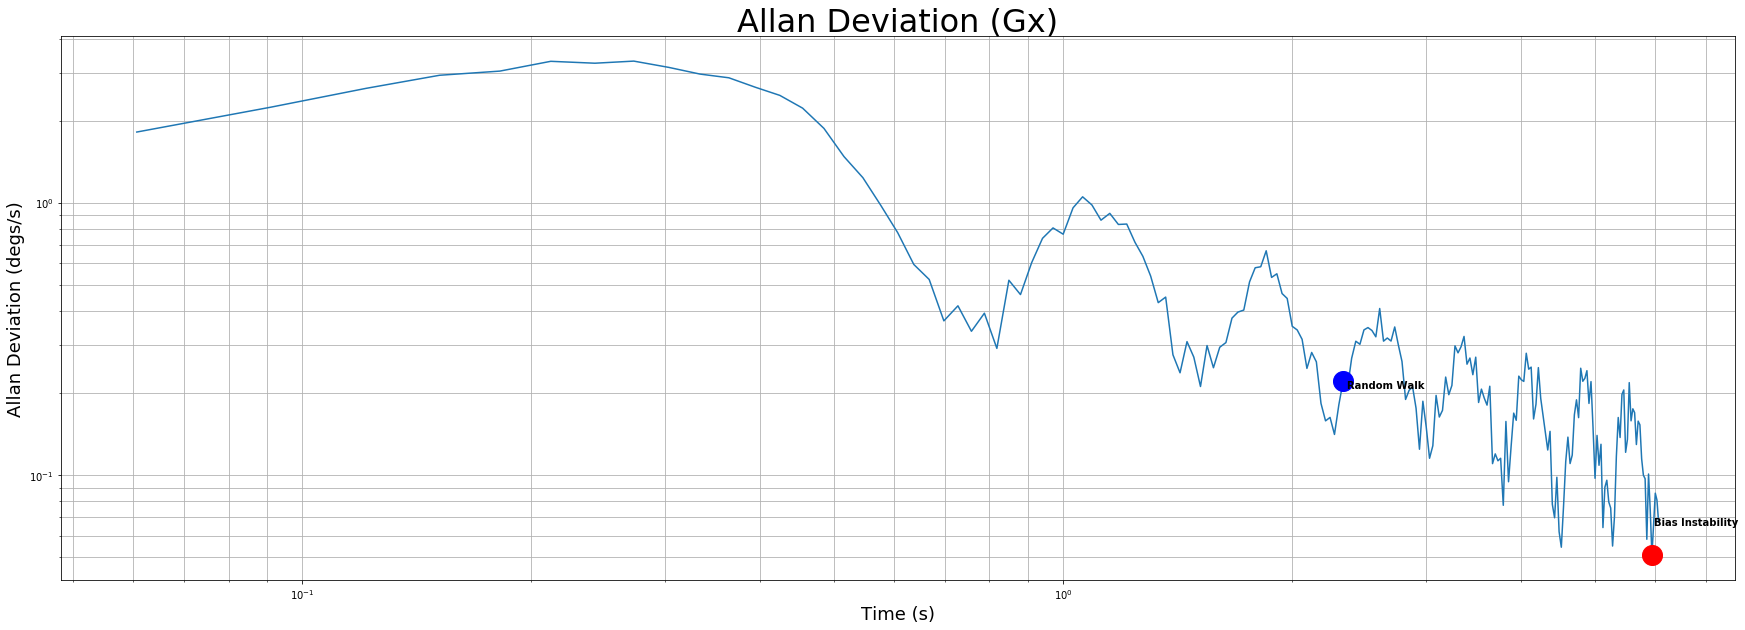

Bias Instability: 205.29097166767158 (deg/h^2)
Angle Random Walk: 20.7666336709112 (deg/sqrt(h))


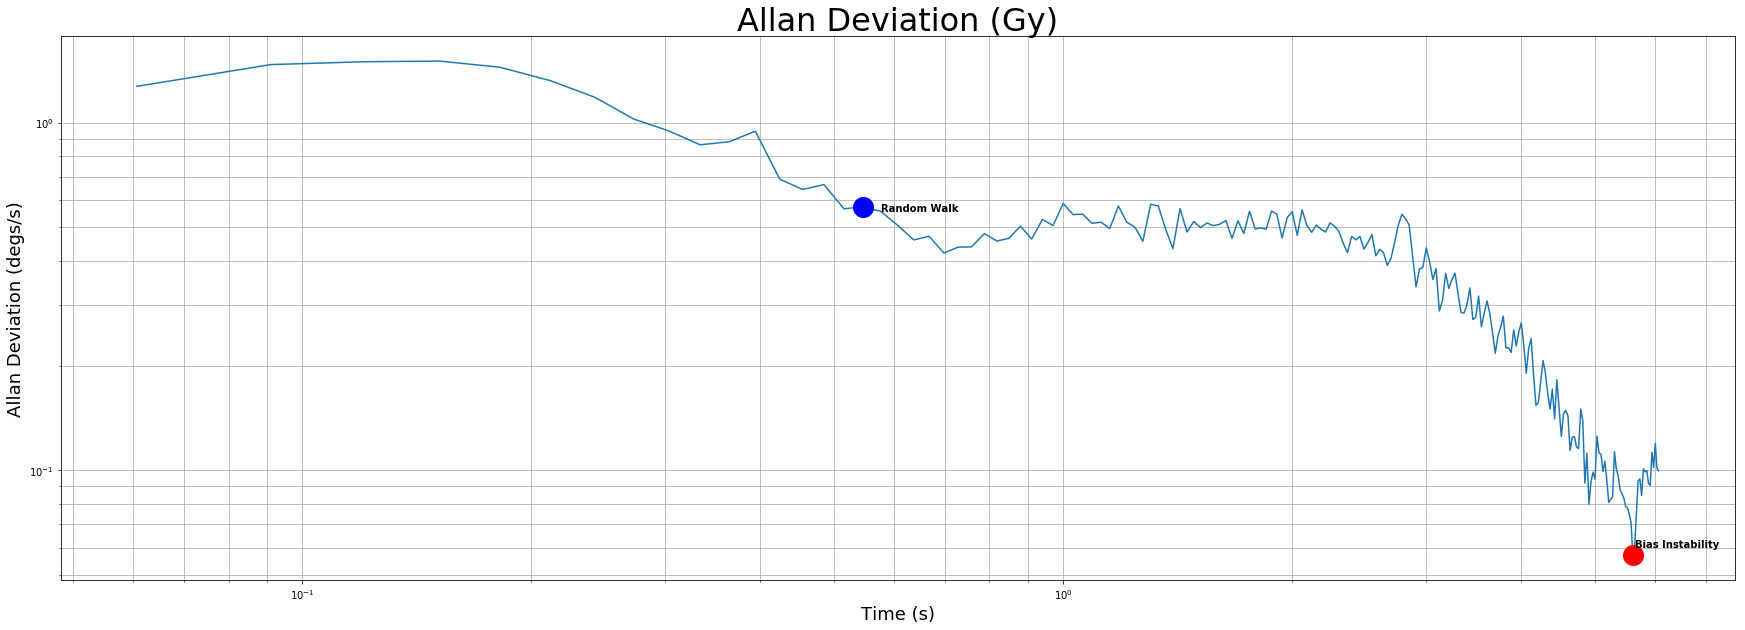

Bias Instability: 61.61647680209274 (deg/h^2)
Angle Random Walk: 11.481150918655327 (deg/sqrt(h))


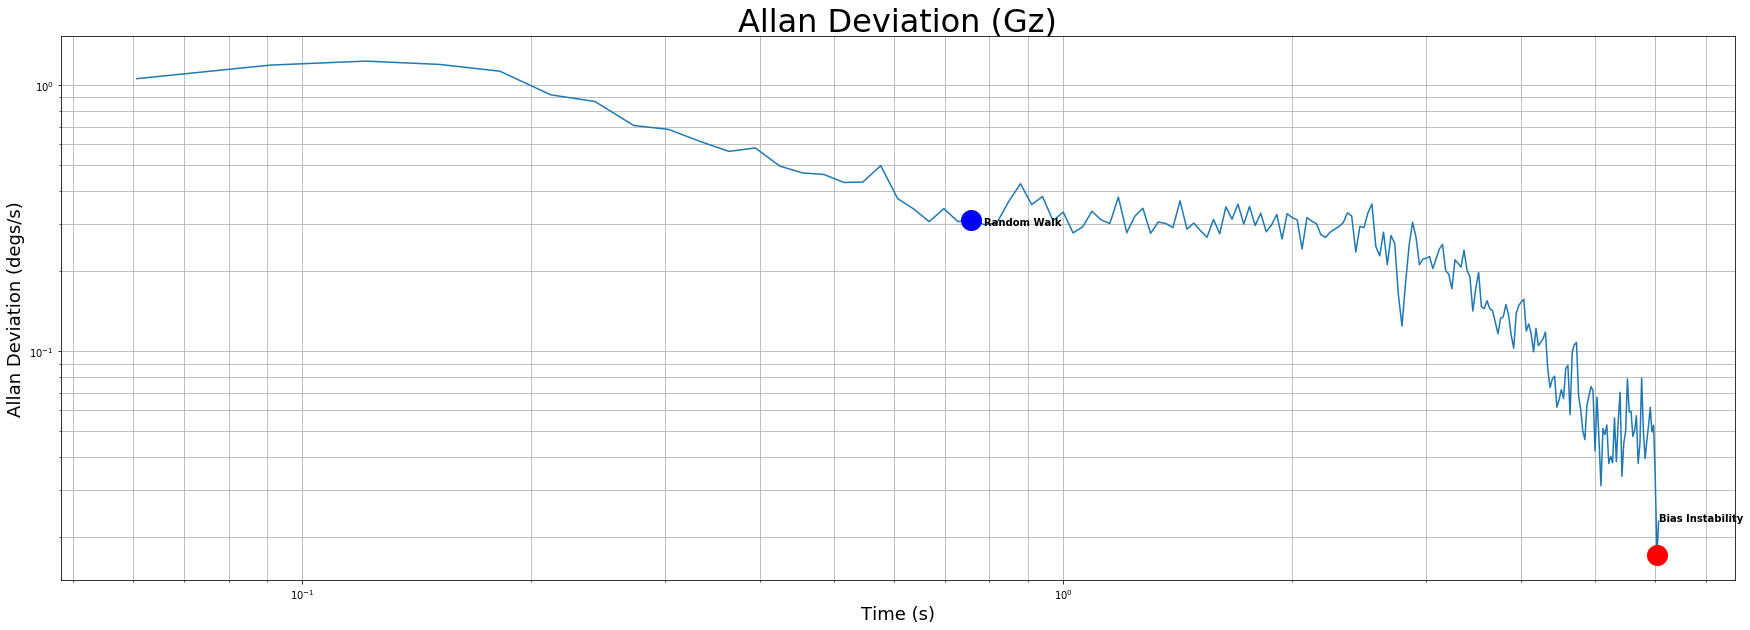

In [69]:
# Determine allan variance for all sets of data (accelerometer and gyroscope)
getAllanVar(d_aXG, 'Ax')
getAllanVar(d_aYG, 'Ay')
getAllanVar(d_aZG, 'Az')
getAllanVar(d_gX, 'Gx')
getAllanVar(d_gY, 'Gy')
getAllanVar(d_gZ, 'Gz')

## Corrected Graphs

In [62]:
#Remove bias instability (subtract bias)
corrAX  = d_aXG - 0.1192881987346046
corrAY  = d_aYG + 0.06489096972934068 #adding because acceleration was originally negative
corrAZ  = d_aZG - 0.09057175153989808
corrGX  = d_gX - 0.14095719297538403
corrGY  = d_gY - 0.4220018861632758
corrGZ  = d_gZ - 0.2424918958191766

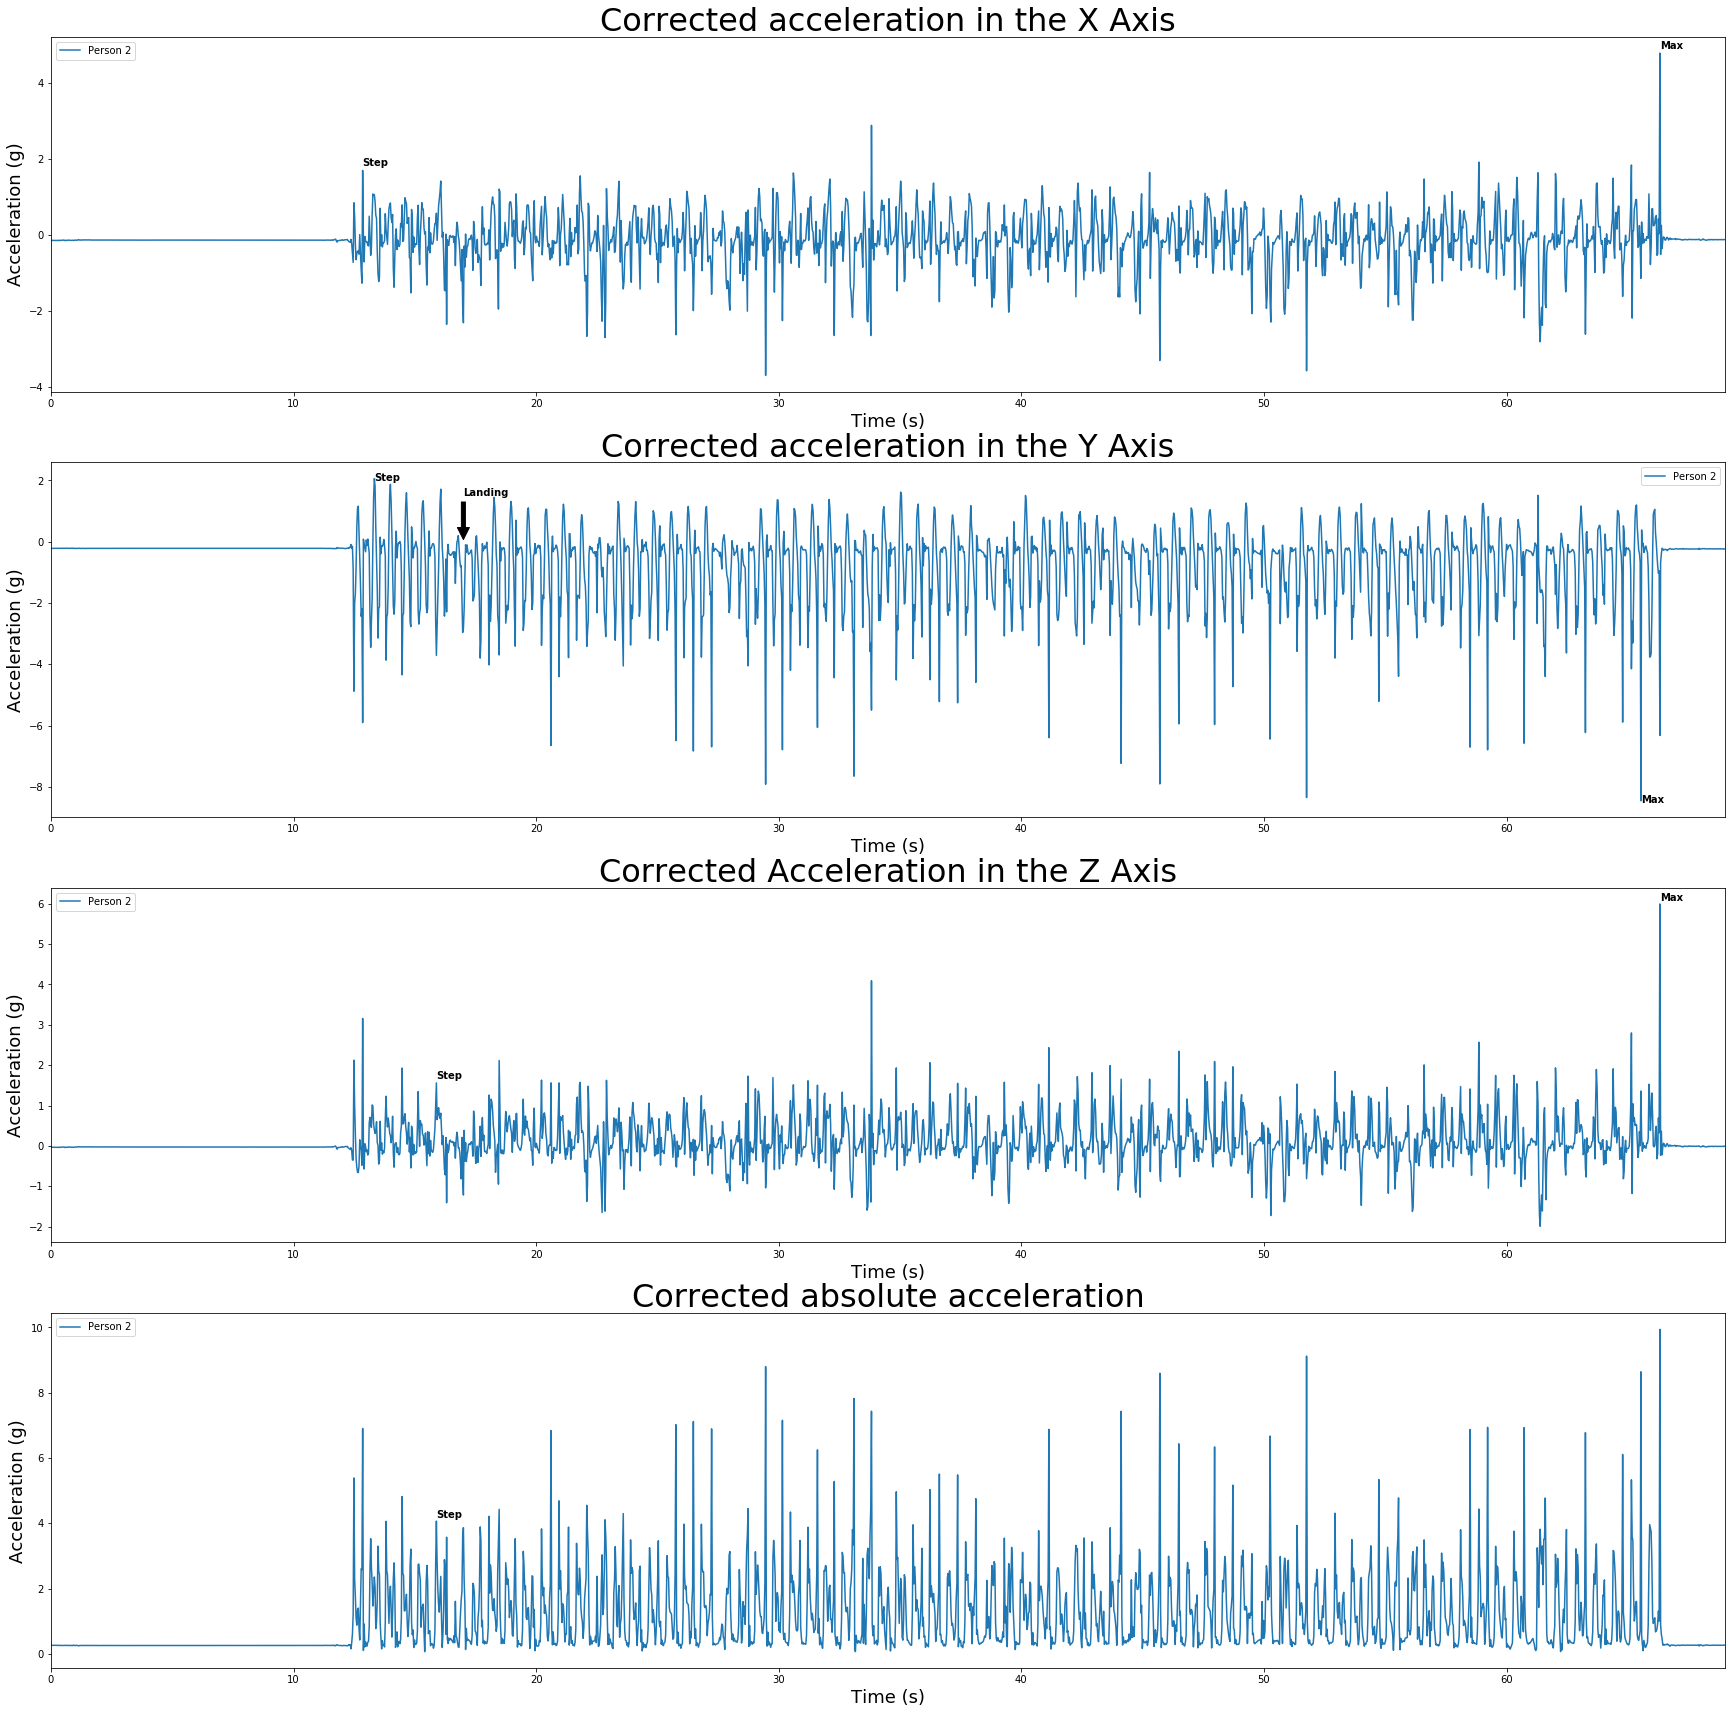

In [63]:
# Acceleration
plt.figure(figsize = (30,30))
corrAbsAcc = getAbsVals(corrAX, corrAY, corrAZ)

ylabel = 'Acceleration (g)'
plt.subplot(4,1,1)
plt.title('Corrected acceleration in the X Axis', fontsize=32)
plotVals(d_aTime, corrAX,'Person 2')
plt.annotate('Max', xy=(getMaxIndex(d_aTime,d_aXG),getMaxElement(d_aXG)), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_aTime,d_aXG[:500]), getMaxPosElement(d_aXG[:500])), weight='bold')

plt.subplot(4,1,2)
plt.title('Corrected acceleration in the Y Axis', fontsize=32)
plotVals(d_aTime, corrAY,'Person 2')
plt.annotate('Max', xy=(getMaxIndex(d_aTime,d_aYG),getMaxElement(d_aYG)), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_aTime,d_aYG[:500]), getMaxPosElement(d_aYG[:500])), weight='bold')
plt.annotate('Landing', xy=(17,0), xytext=(17,1.5), weight='bold', arrowprops=dict(facecolor='black', shrink=0.05))

plt.subplot(4,1,3)
plt.title('Corrected Acceleration in the Z Axis', fontsize=32)
plotVals(d_aTime, corrAZ,'Person 2')
plt.annotate('Max', xy=(getMaxIndex(d_aTime,d_aZG),getMaxElement(d_aZG)), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_aTime[500:600],d_aZG[500:600]), getMaxPosElement(d_aZG[500:600])), weight='bold')

plt.subplot(4,1,4)
plt.title('Corrected absolute acceleration', fontsize=32)
plotVals(d_aTime, corrAbsAcc,'Person 2')
plt.annotate('Step', xy=(getMaxPosIndex(d_aTime[500:600],d_absVals[500:600]), getMaxPosElement(d_absVals[500:600])), weight='bold')

plt.show()

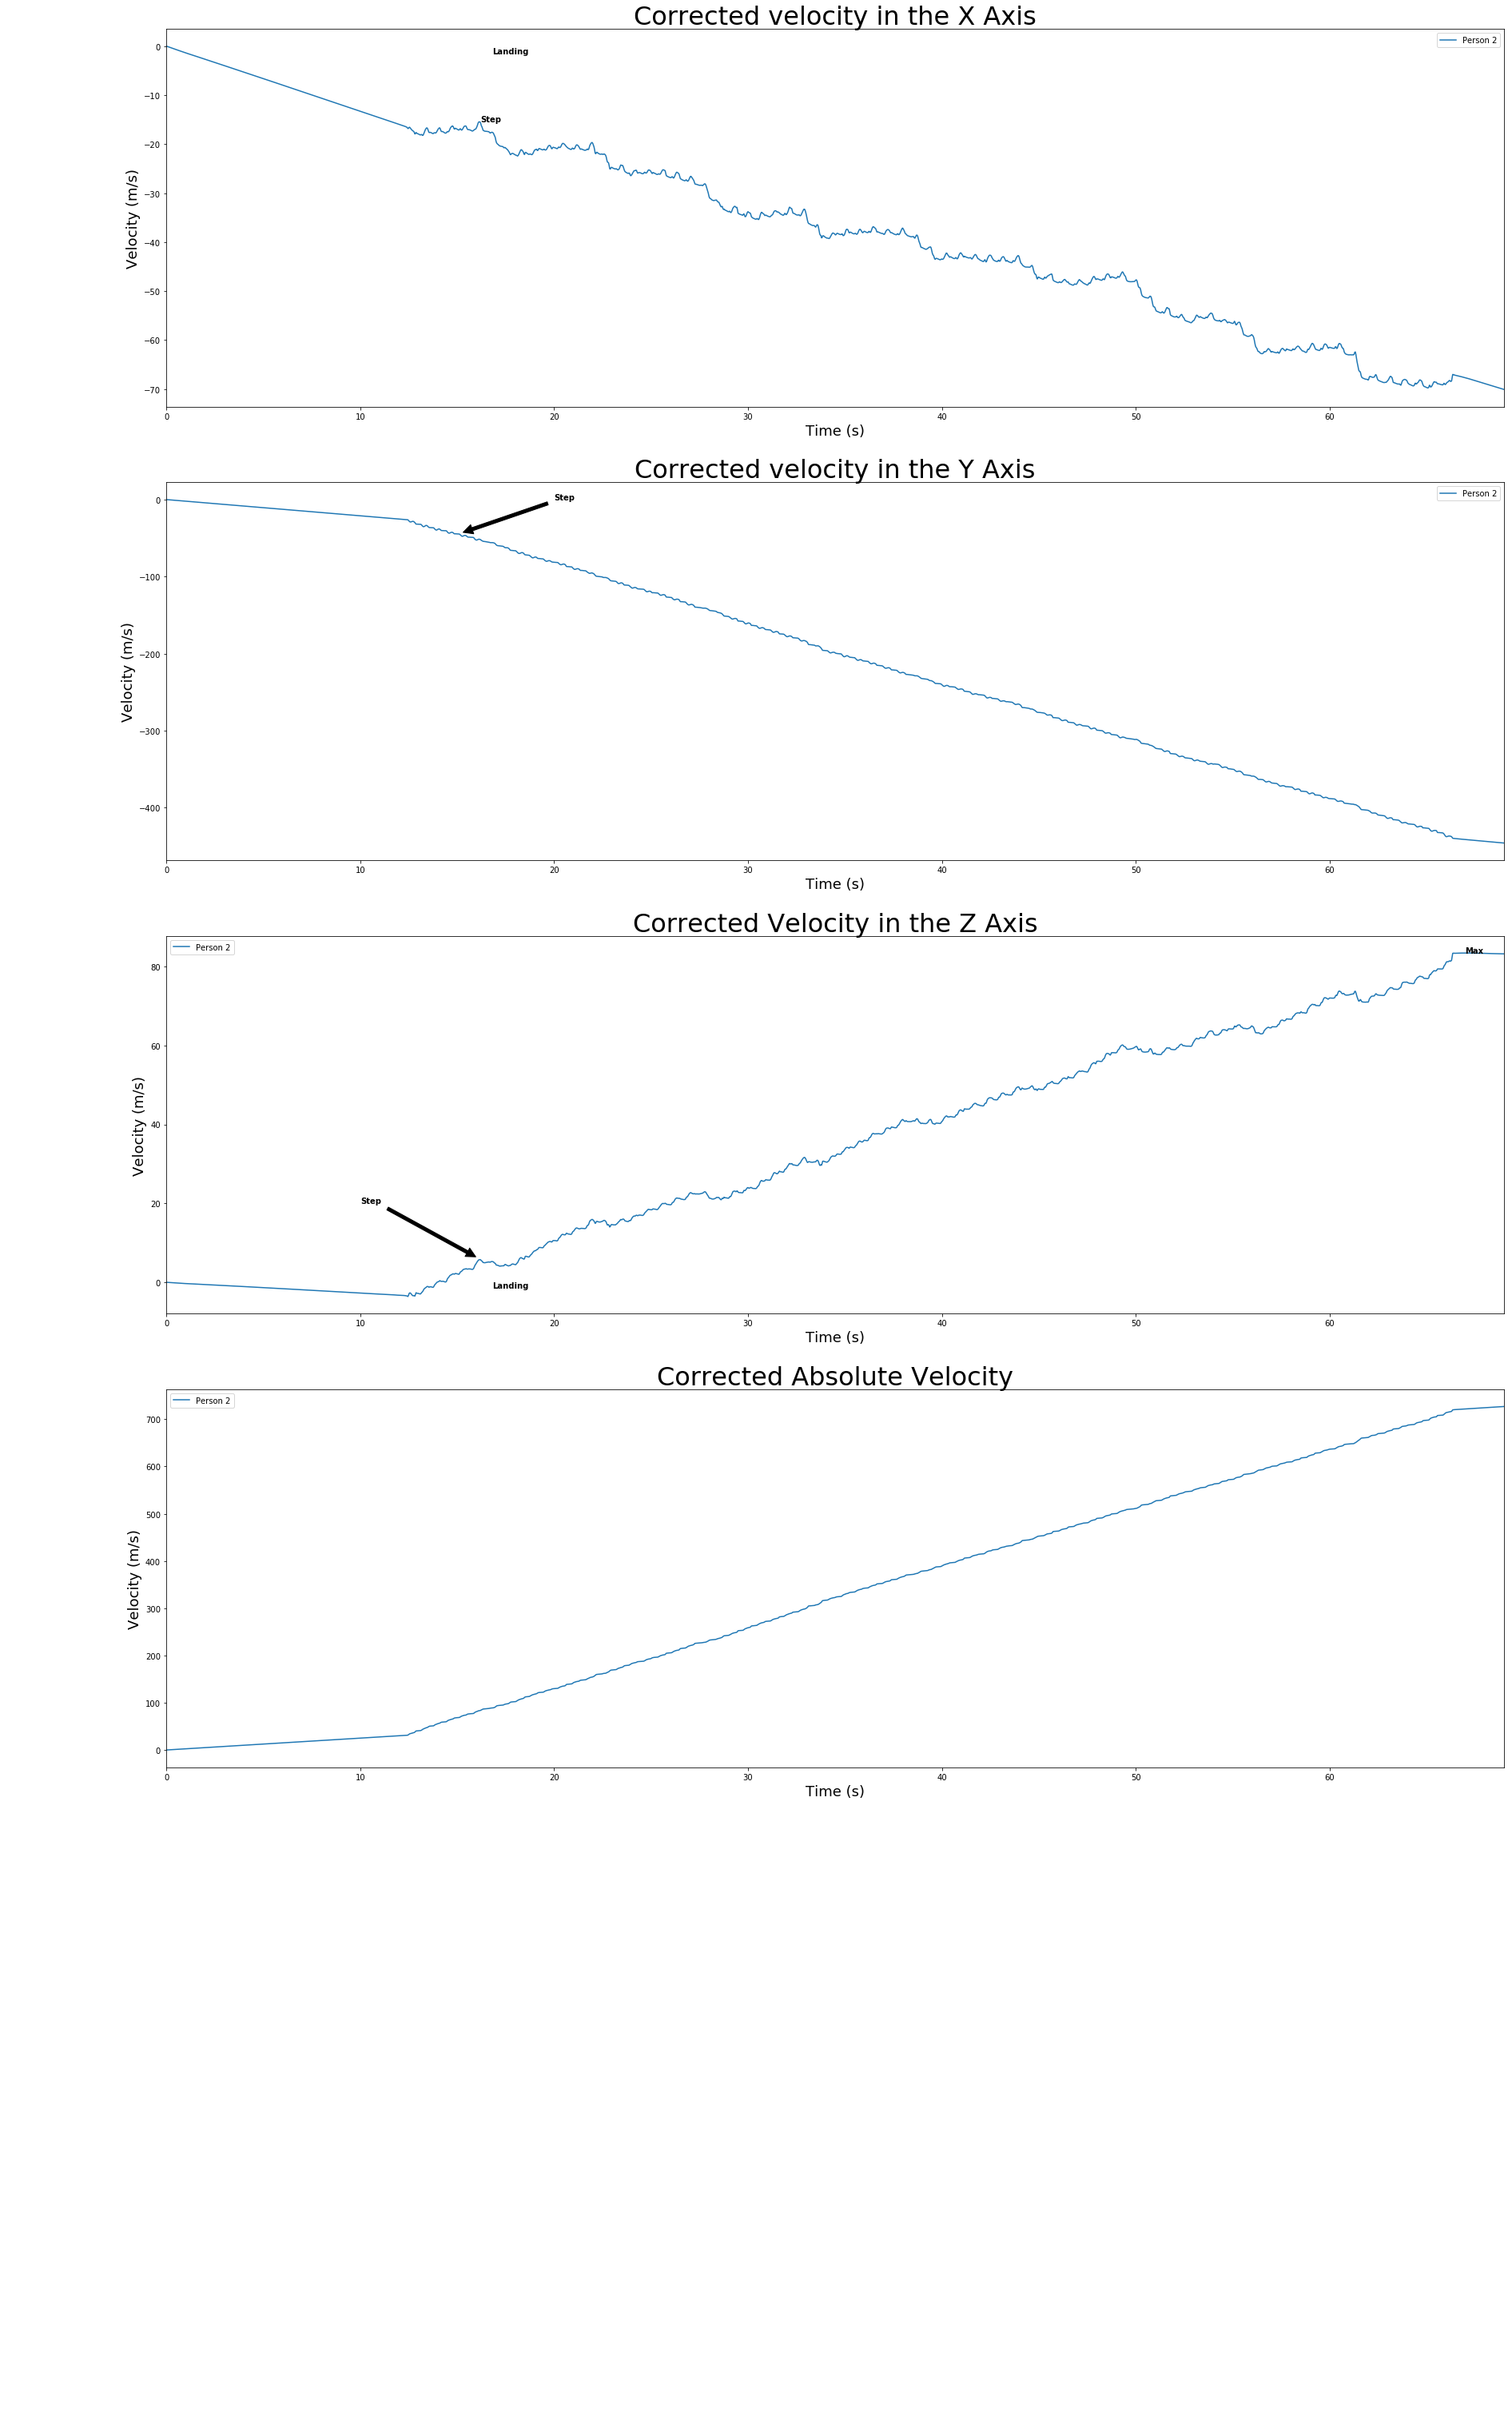

In [64]:
#Velocity

#Update acceleration units
corrAX2 = fixUnits(corrAX)
corrAY2 = fixUnits(corrAY)
corrAZ2 = fixUnits(corrAZ)
corrAbsAcc2 = fixUnits(corrAbsAcc)

plt.figure(figsize = (30,40))
plt.subplot(4,1,1)
ylabel = 'Velocity (m/s)'
plt.title('Corrected velocity in the X Axis', fontsize=32)
plotVals(d_aTime, getIntegral(corrAX2, d_aTime, 0), 'Person 2')
plt.annotate('Max', xy=(getMaxIndex(d_gTime,getIntegral(corrAX2, d_aTime, 0)),getMaxElement(getIntegral(corrAX2, d_aTime, 0))), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_gTime[500:550],getIntegral(corrAX2, d_aTime, 0)[500:550]), 
                         getMaxPosElement(getIntegral(corrAX2, d_aTime, 0)[500:550])), weight='bold')
plt.annotate('Landing', xy=(16.8,-5), xytext=(16.8,-1.5), weight='bold')

plt.subplot(4,1,2)
plt.title('Corrected velocity in the Y Axis', fontsize=32)
plotVals(d_aTime, getIntegral(corrAY2, d_aTime, 0), 'Person 2')
plt.annotate('Max', xy=(getMaxIndex(d_gTime,getIntegral(corrAY2, d_aTime, 0)),getMaxElement(getIntegral(corrAY2, d_aTime, 0))), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_gTime[500:550],getIntegral(corrAY2, d_aTime, 0)[500:550]), 
                         getMaxPosElement(getIntegral(corrAY2, d_aTime, 0)[500:550])), weight='bold',
            xytext=(20,0), arrowprops=dict(facecolor='black', shrink=0.05))

plt.subplot(4,1,3)
plt.title('Corrected Velocity in the Z Axis', fontsize=32)
plotVals(d_aTime, getIntegral(corrAZ2, d_aTime, 0), 'Person 2')
plt.annotate('Max', xy=(getMaxIndex(d_gTime,getIntegral(corrAZ2, d_aTime, 0)),getMaxElement(getIntegral(corrAZ2, d_aTime, 0))), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_gTime[500:550],getIntegral(corrAZ2, d_aTime, 0)[500:550]), 
                         getMaxPosElement(getIntegral(corrAZ2, d_aTime, 0)[500:550])), weight='bold',
            xytext=(10,20), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Landing', xy=(16.8,0), xytext=(16.8,-1.5), weight='bold')

plt.subplot(4,1,4)
plt.title('Corrected Absolute Velocity', fontsize=32)
plotVals(d_aTime, getIntegral(corrAbsAcc2, d_aTime, 0), 'Person 2')
plt.annotate('Max', xy=(getMaxIndex(d_gTime,d_vAbsVals), getMaxElement(d_vAbsVals)), weight='bold')

plt.show()

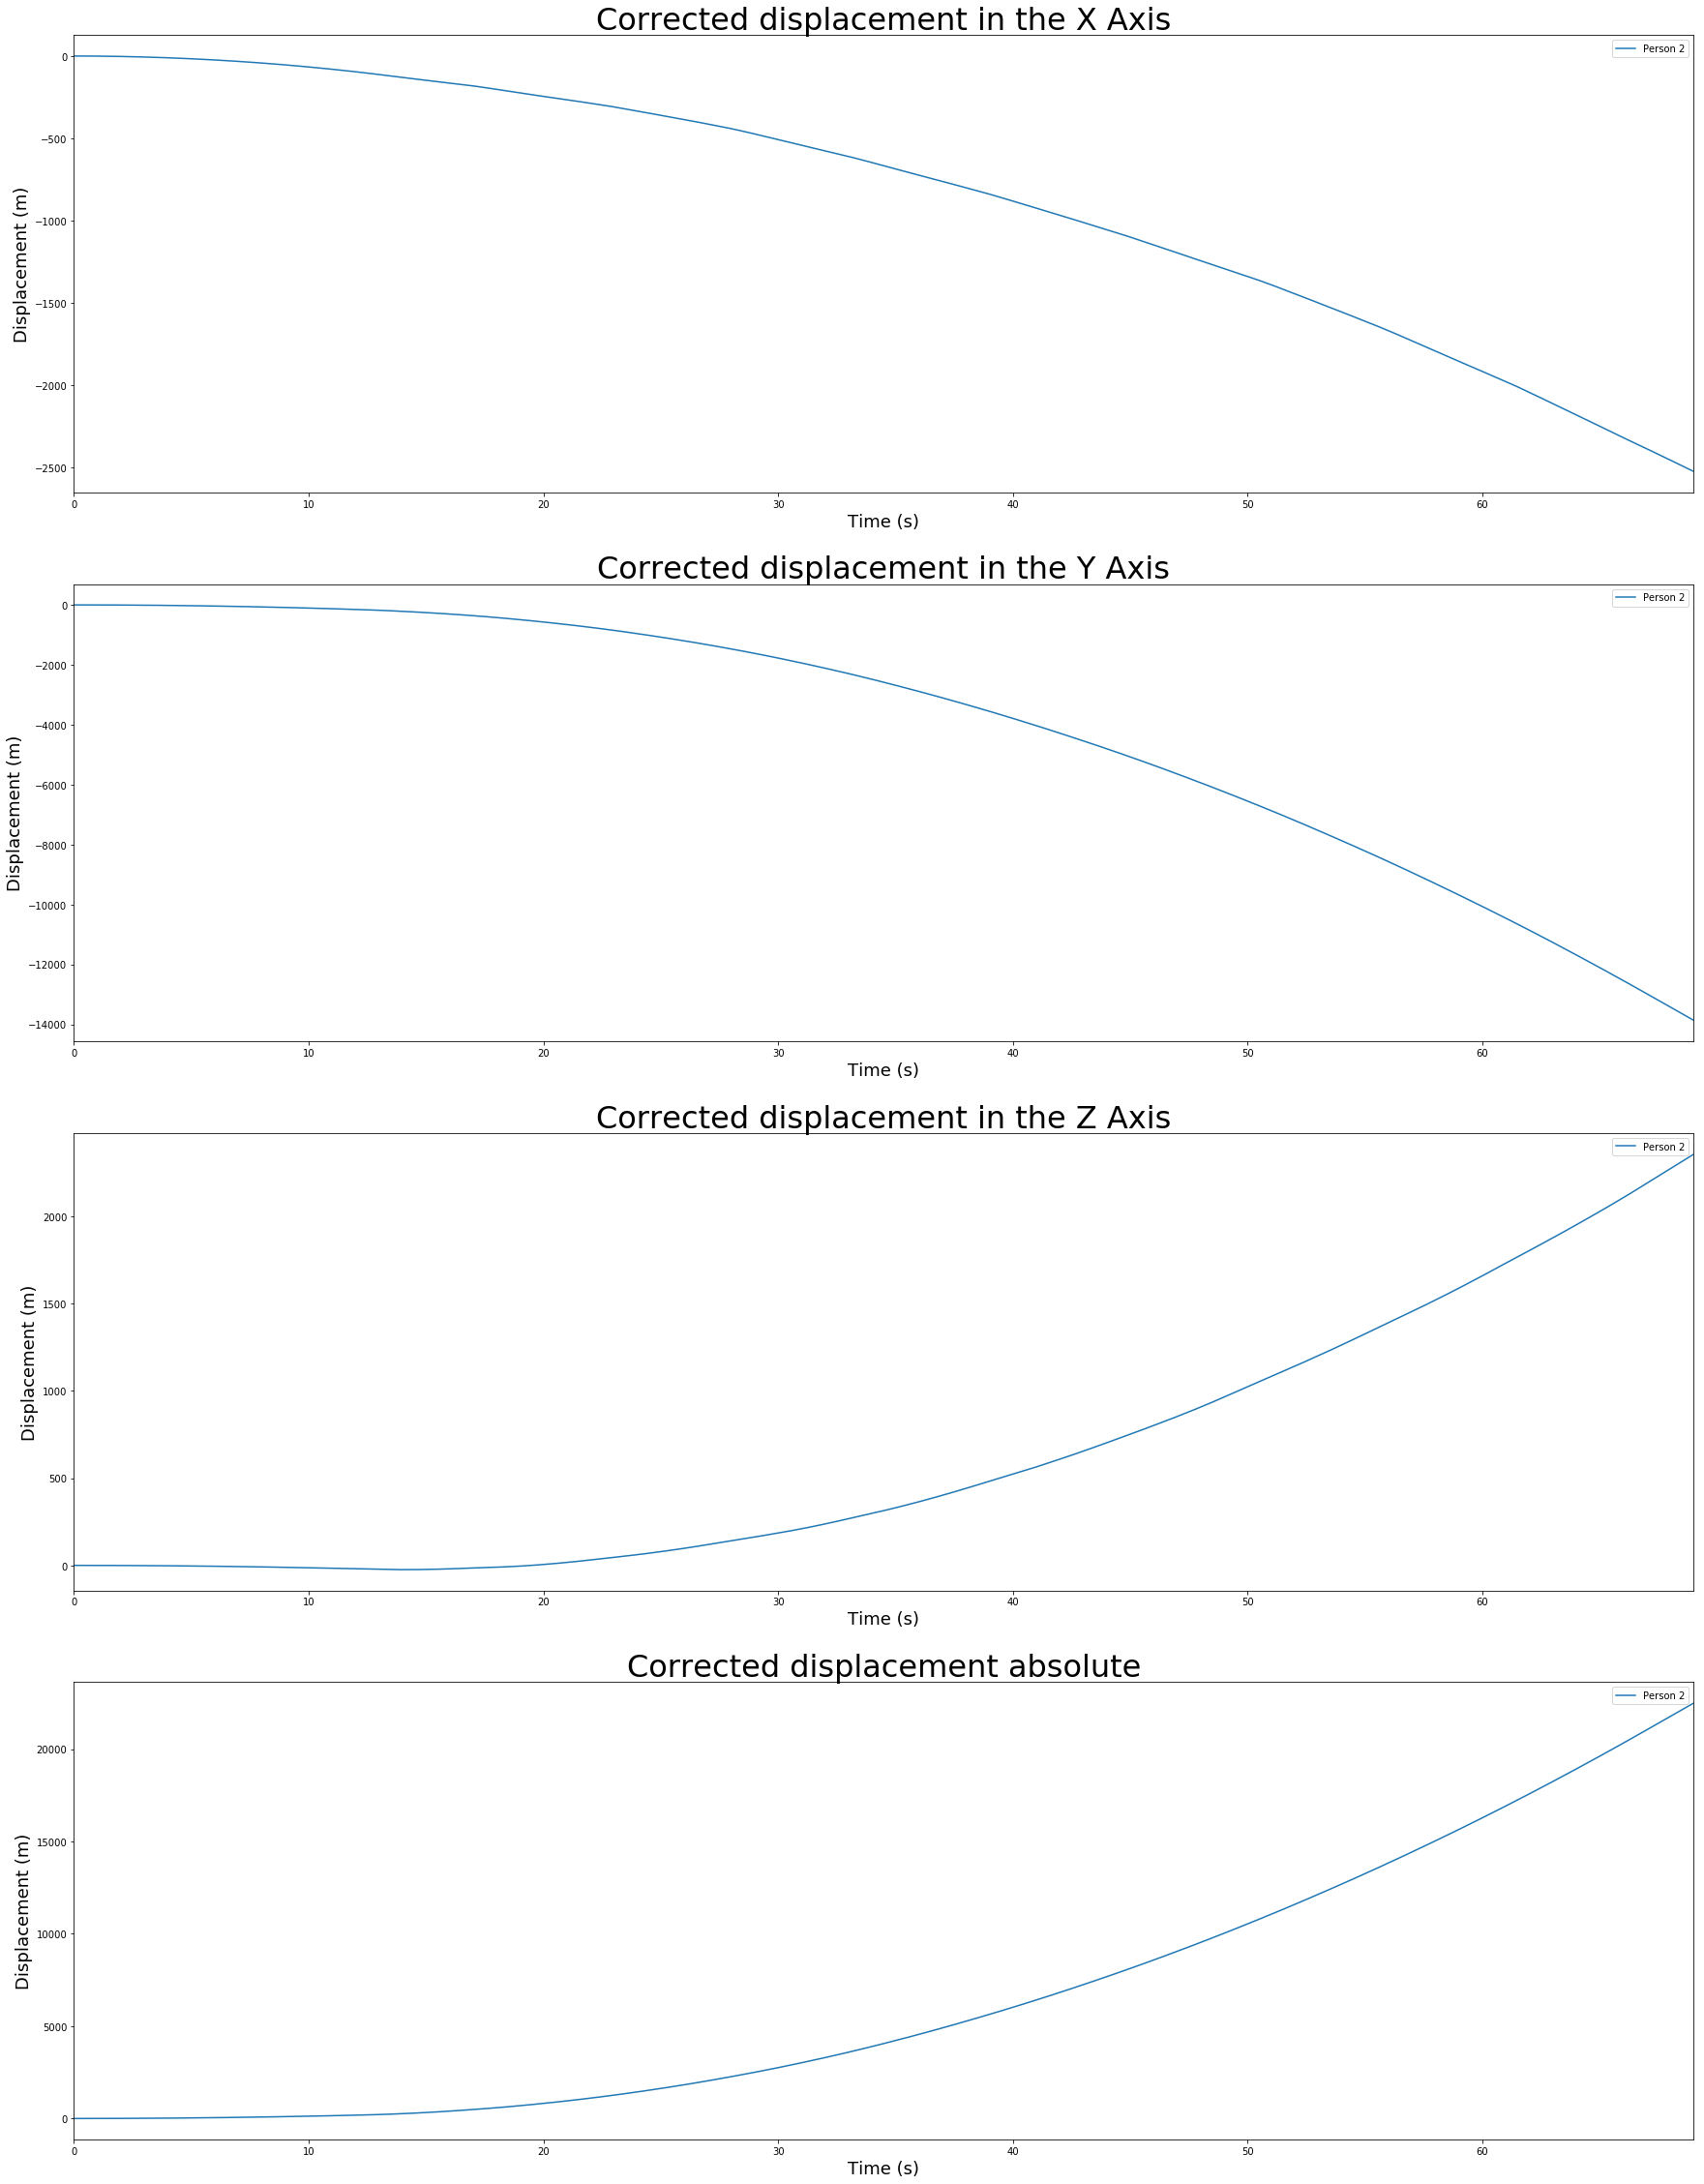

In [65]:
#Distance

#Distance X
corrDX = getPosition(corrAX2, d_aTime, 0)

#Distance Y
corrDY = getPosition(corrAY2, d_aTime, 0)

#Distance Z
corrDZ = getPosition(corrAZ2, d_aTime, 0)

#Distance Absolute
corrAbsDis = getPosition(corrAbsAcc2, d_aTime, 0)

ylabel = 'Displacement (m)'

plt.figure(figsize = (30,40))
plt.subplot(4,1,1)
plt.title("Corrected displacement in the X Axis", fontsize=32)
plotVals(d_aTime, corrDX, 'Person 2')

plt.subplot(4,1,2)
plt.title("Corrected displacement in the Y Axis", fontsize=32)
plotVals(d_aTime, corrDY, 'Person 2')

plt.subplot(4,1,3)
plt.title("Corrected displacement in the Z Axis", fontsize=32)
plotVals(d_aTime, corrDZ, 'Person 2')

#Absolute Distance plot
plt.subplot(4,1,4)
plt.title("Corrected displacement absolute", fontsize=32)
plotVals(d_aTime, corrAbsDis, 'Person 2')

plt.show()

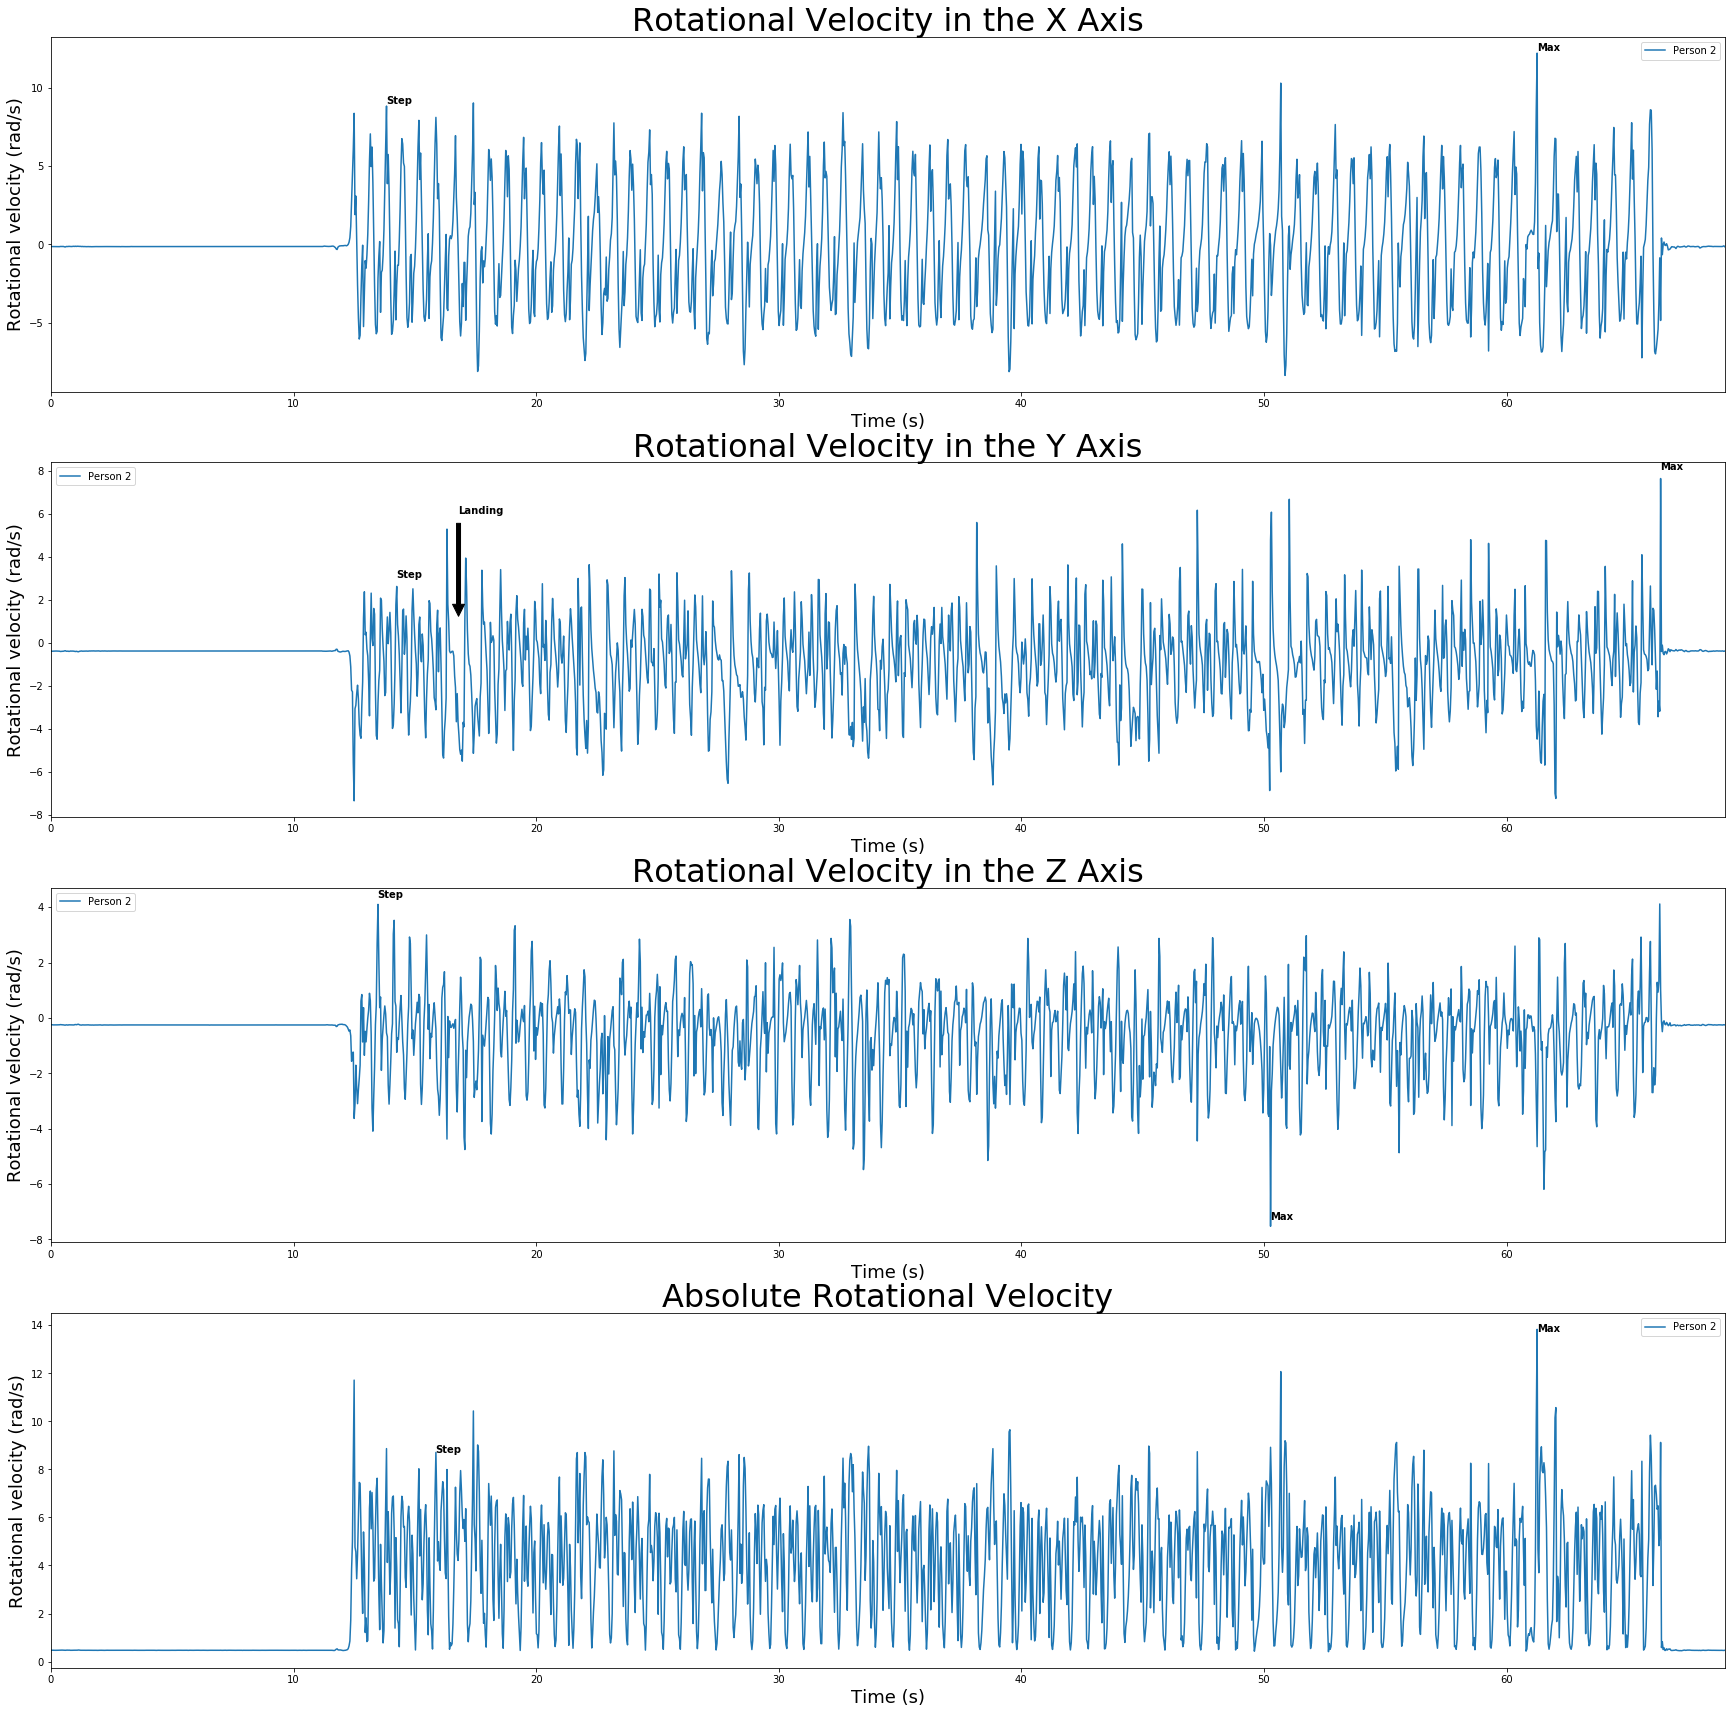

In [66]:
#plot rotational velocities
corrAbsGyro = getAbsVals(corrGX, corrGY, corrGZ)

plt.figure(figsize = (30,30))
d_gTime = d_gTime - d_gTime[0]
ylabel = 'Rotational velocity (rad/s)'
plt.subplot(4,1,1)
plt.title('Rotational Velocity in the X Axis', fontsize = 32)
plotVals(d_gTime, corrGX, 'Person 2')
plt.annotate('Max', xy=(getMaxIndex(d_gTime,d_gX),getMaxElement(d_gX)), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_aTime[:500],d_gX[:500]), getMaxPosElement(d_gX[:500])), weight='bold')

plt.subplot(4,1,2)
plt.title('Rotational Velocity in the Y Axis', fontsize = 32)
plotVals(d_gTime, corrGY, 'Person 2')
plt.annotate('Max', xy=(getMaxIndex(d_gTime,d_gY),getMaxElement(d_gY)), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_aTime,d_gY[:500]), getMaxPosElement(d_gY[:500])), weight='bold')
plt.annotate('Landing', xy=(16.8,1), xytext=(16.8,6), weight='bold', arrowprops=dict(facecolor='black', shrink=0.05))

plt.subplot(4,1,3)
plt.title('Rotational Velocity in the Z Axis', fontsize = 32)
plotVals(d_gTime, corrGZ, 'Person 2')
plt.annotate('Max', xy=(getMaxIndex(d_gTime,d_gZ),getMaxElement(d_gZ)), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_aTime,d_gZ[:500]), getMaxPosElement(d_gZ[:500])), weight='bold')

plt.subplot(4,1,4)
plt.title('Absolute Rotational Velocity', fontsize = 32)
plotVals(d_gTime, corrAbsGyro, 'Person 2')
plt.annotate('Max', xy=(getMaxIndex(d_gTime,d_absGVals),getMaxElement(d_absGVals)), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_aTime[500:550],d_absGVals[500:550]), getMaxPosElement(d_absGVals[500:550])), weight='bold')

plt.show()

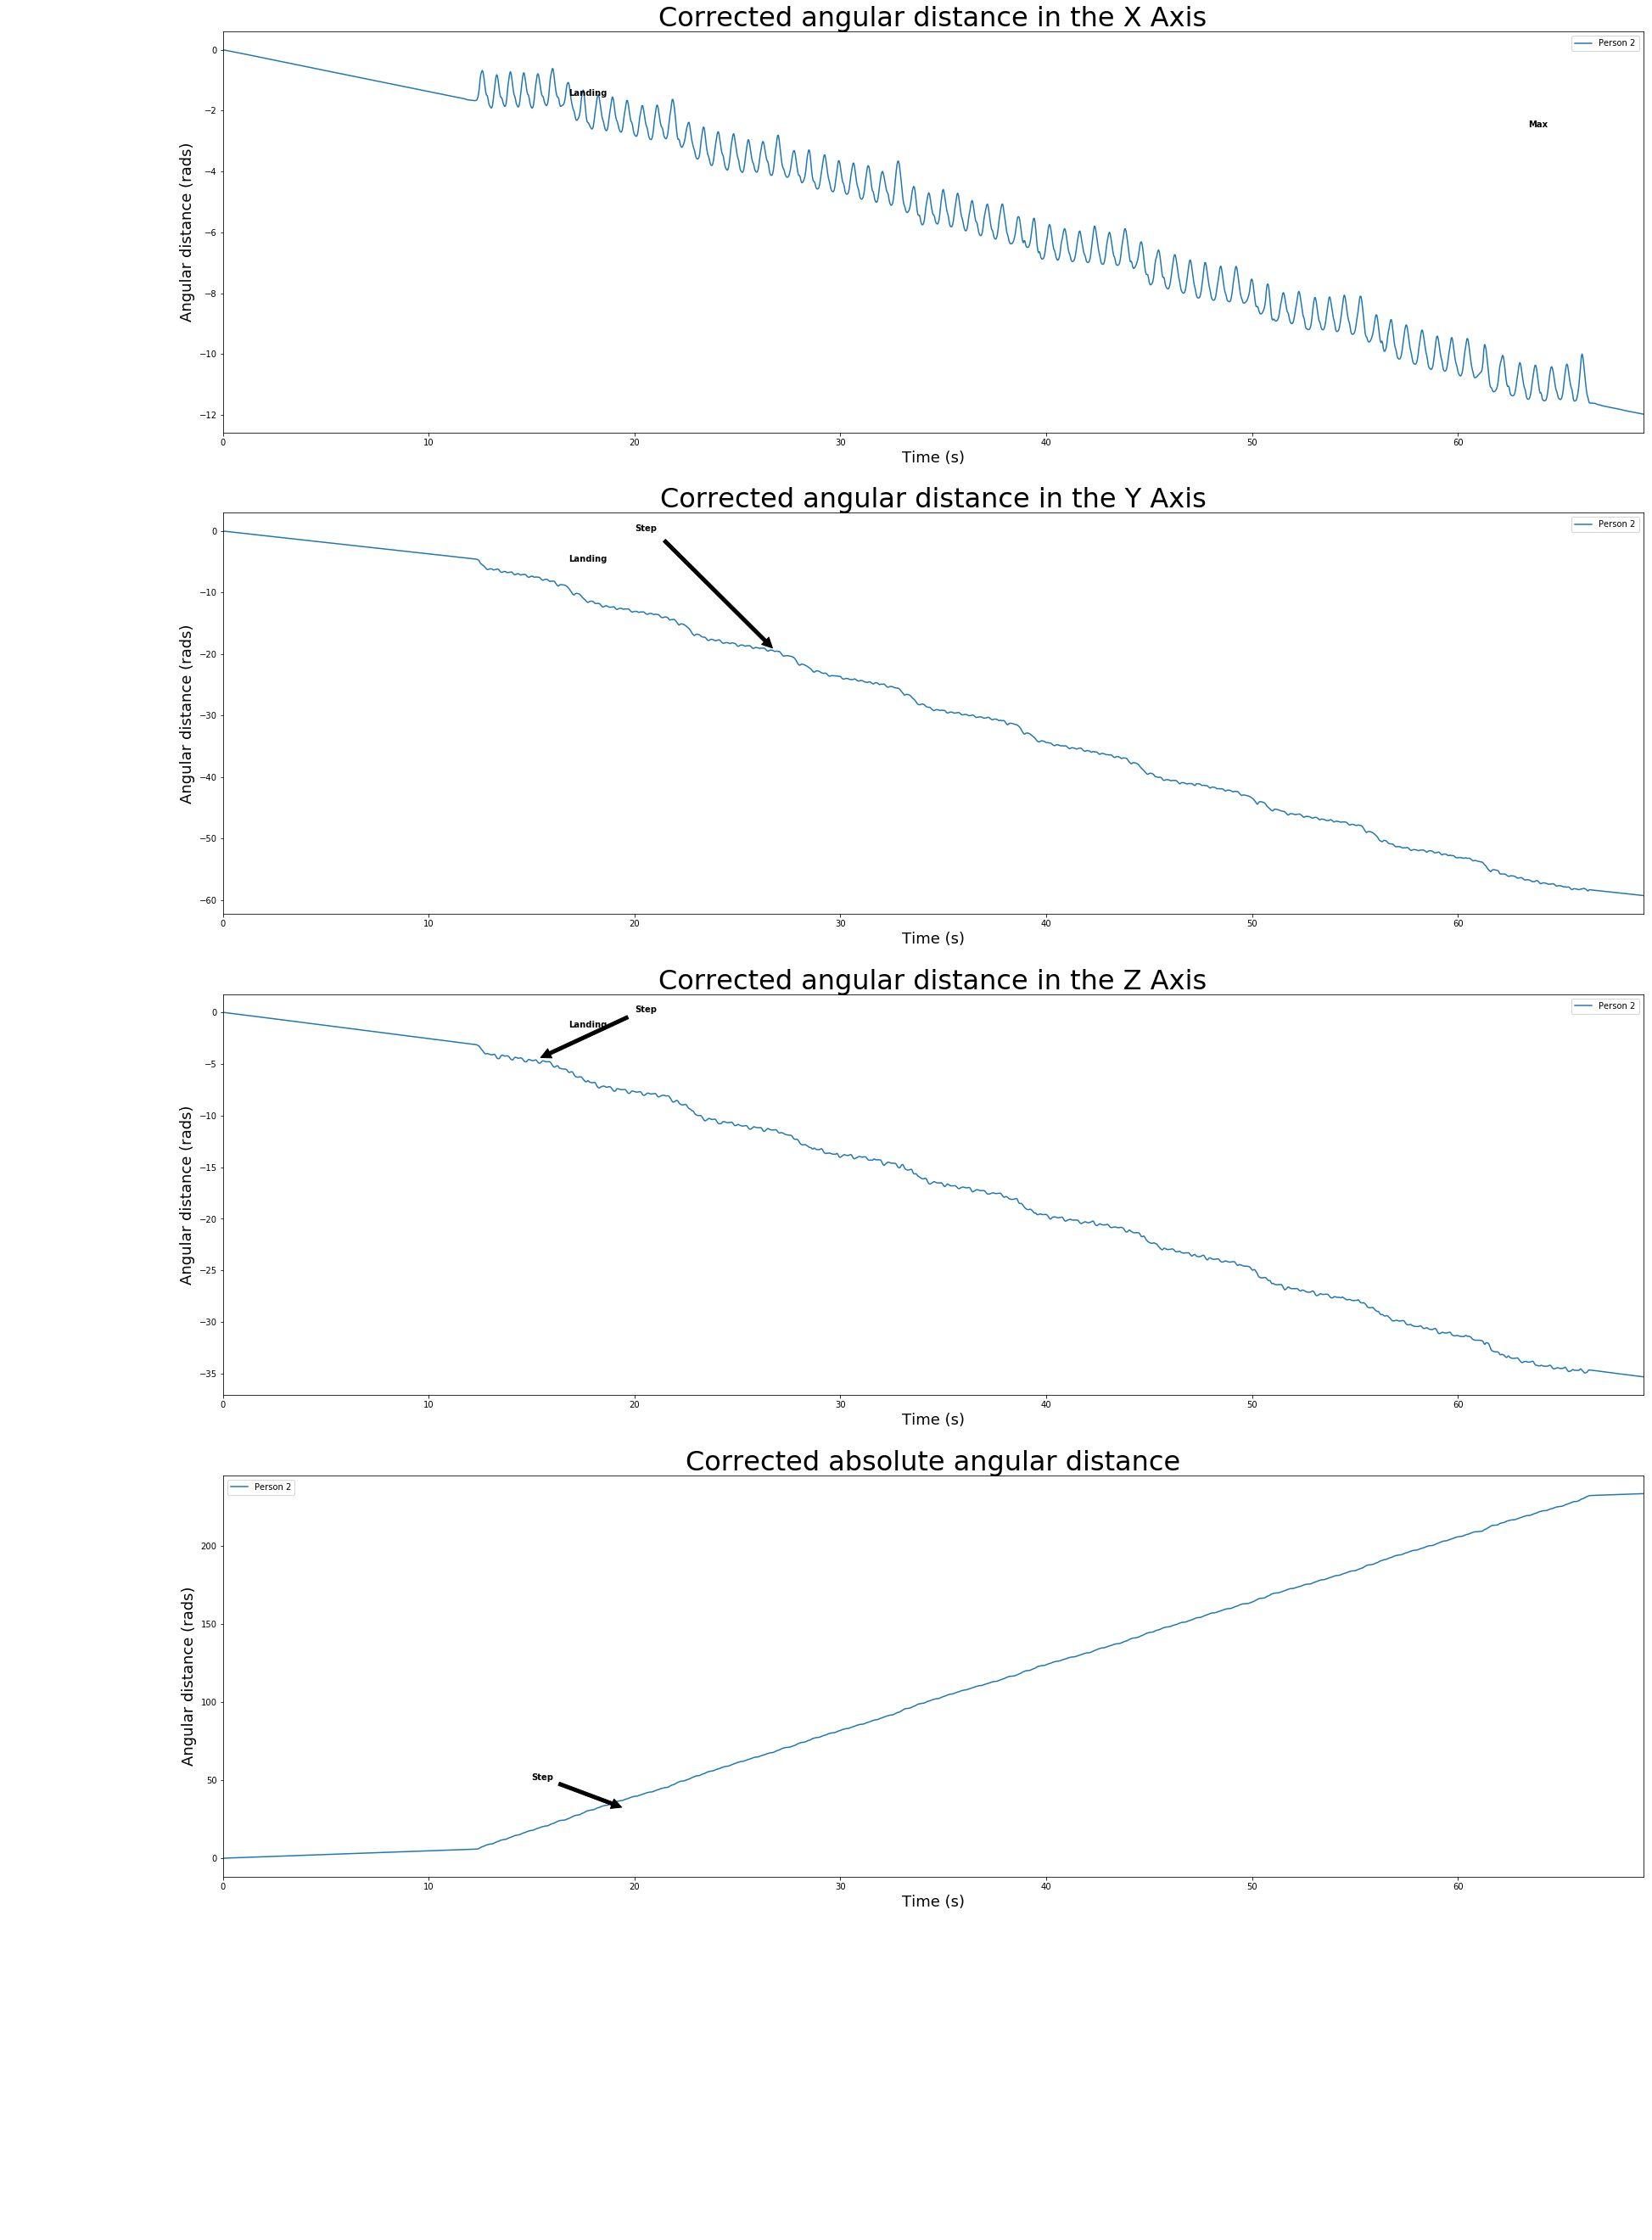

In [67]:
#Graph corrected values

plt.figure(figsize = (30,40))
plt.subplot(4,1,1)
ylabel = 'Angular distance (rads)'
plt.title('Corrected angular distance in the X Axis', fontsize = 32)
plotVals(d_gTime, getIntegral(corrGX, d_gTime, 0), 'Person 2')
plt.annotate('Max', xy=(getMaxIndex(d_gTime,d_gdX),getMaxElement(d_gdX)), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_gTime,d_gdX[:500]), getMaxPosElement(d_gdX[:500])), weight='bold')
plt.annotate('Landing', xy=(16.8,0), xytext=(16.8,-1.5), weight='bold')

plt.subplot(4,1,2)
plt.title('Corrected angular distance in the Y Axis', fontsize = 32)
plotVals(d_gTime, getIntegral(corrGY, d_gTime, 0), 'Person 2')
plt.annotate('Max', xy=(getMaxIndex(d_gTime,getIntegral(corrGY, d_gTime, 0)),getMaxElement(getIntegral(corrGY, d_gTime, 0))), weight='bold')
plt.annotate('Step', xy=(27,-20), weight='bold',
             xytext=(20,0), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Landing', xy=(16.8,0), xytext=(16.8,-5), weight='bold')

plt.subplot(4,1,3)
plt.title('Corrected angular distance in the Z Axis', fontsize = 32)
plotVals(d_gTime, getIntegral(corrGZ, d_gTime, 0), 'Person 2')
plt.annotate('Max', xy=(getMaxIndex(d_gTime,getIntegral(corrGZ, d_gTime, 0)),getMaxElement(getIntegral(corrGZ, d_gTime, 0))), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_gTime[500:550],getIntegral(corrGZ, d_gTime, 0)[500:550]), 
                         getMaxPosElement(getIntegral(corrGZ, d_gTime, 0)[500:550])), weight='bold',
             xytext=(20,0), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Landing', xy=(22,-10), xytext=(16.8,-1.5), weight='bold')

plt.subplot(4,1,4)
plt.title('Corrected absolute angular distance', fontsize = 32)
plotVals(d_gTime, getIntegral(corrAbsGyro, d_gTime, 0), 'Person 2')
plt.annotate('Max', xy=(getMaxIndex(d_gTime,d_gdAbsVals),
                                 getMaxElement(d_gdAbsVals)), weight='bold')
plt.annotate('Step', xy=(getMaxPosIndex(d_gTime[600:650],d_gdAbsVals[600:650]), 
                         getMaxPosElement(d_gdAbsVals[600:650])), weight='bold',
             xytext=(15,50), arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()